In [1]:
""" 
21 MARCH 2024 
Theo Gauvrit
Testing if the responsivity pattern are different between WT and KO groups
"""

import percephone.core.recording as pc
import percephone.plts.behavior as pbh
import percephone.plts.stats as ppt
import percephone.analysis.mlr_models as mlr_m
import numpy as np
import pandas as pd
import scipy.stats as ss
from multiprocessing import Pool, cpu_count, pool
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import pingouin as pg
from statsmodels.formula.api import ols

plt.rcParams['font.size'] = 30
plt.rcParams['axes.linewidth'] = 2
plt.switch_backend("Qt5Agg")
matplotlib.use("Qt5Agg")
%matplotlib inline
fontsize = 20

In [2]:
user = "Adrien"

if user == "Célien":
    directory = "C:/Users/cvandromme/Desktop/Data/"
    roi_path = "C:/Users/cvandromme/Desktop/FmKO_ROIs&inhibitory.xlsx"
elif user == "Théo":
    directory = "/datas/Théo/Projects/Percephone/data/Amplitude_Detection/loop_format_tau_02/"
    roi_path = directory + "/FmKO_ROIs&inhibitory.xlsx"
elif user == "Adrien":
    directory = "C:/Users/acorniere/Desktop/percephone_data/"
    roi_path = directory + "FmKO_ROIs&inhibitory.xlsx"    
    
roi_info = pd.read_excel(roi_path)
files = os.listdir(directory)
files_ = [file for file in files if file.endswith("synchro")]

def opening_rec(fil, i):
    rec = pc.RecordingAmplDet(directory + fil + "/", 0, roi_path)
    return rec

workers = cpu_count()
if user == "Célien":
    pool = pool.ThreadPool(processes=workers)
elif user == "Théo":
   pool = Pool(processes=workers)
elif user == "Adrien":
    pool = pool.ThreadPool(processes=workers)   
async_results = [pool.apply_async(opening_rec, args=(file, i)) for i, file in enumerate(files_)]
recs = {ar.get().filename: ar.get() for ar in async_results}

Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorpor

In [3]:
def fraction_resp( pattern, n_type, ko, stim_ampl="all", no_go_normalize=True):
    wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
    for rec in recs.values():
        resp_mat = np.array(rec.matrices[n_type]["Responsivity"])
        no_go_filter = rec.stim_ampl_filter(stim_ampl=[0], include_no_go=True)
        ampl_filter = rec.stim_ampl_filter(stim_ampl=stim_ampl, include_no_go=False)
        ampl_det_filt = np.logical_and(rec.detected_stim, ampl_filter)
        ampl_undet_filt = np.logical_and(np.invert(rec.detected_stim), ampl_filter)
        #detected
        trials_no_go = resp_mat[:, no_go_filter]
        trials_detected = resp_mat[:, ampl_det_filt]
        trials_undetected = resp_mat[:, ampl_undet_filt]
        if pattern == 0:
            trials_detected[trials_detected!=0]=1
            trials_undetected[trials_undetected!=0]=1
            trials_no_go[trials_no_go!=0]=1
        else:
            trials_detected[trials_detected!=pattern]=0
            trials_undetected[trials_undetected!=pattern]=0
            trials_no_go[trials_no_go!=pattern]=0
        
        # The total number of neurons is computed
        total_n = rec.zscore_exc.shape[0] if n_type == "EXC" else rec.zscore_inh.shape[0]
        
        # Computation of the number of responsive neurons
        recruited_det = np.mean(np.count_nonzero(trials_detected,axis=0))
        recruited_undet = np.mean(np.count_nonzero(trials_undetected,axis=0))
        
        # Normalization b the number of responsive neurons for no-go trials
        if no_go_normalize:
            recruited_no_go = np.mean(np.count_nonzero(trials_no_go,axis=0))
            recruited_det -= recruited_no_go
            recruited_undet -= recruited_no_go
            recruited_det = 0 if recruited_det < 0 else recruited_det
            recruited_undet = 0 if recruited_undet < 0 else recruited_undet
        
        # Computation of the percentage of responsive neurons
        perc_n_det = (recruited_det/total_n)*100
        perc_n_undet = (recruited_undet/total_n)*100
        
        # Storing the computed percentage in the corresponding list
        if rec.genotype == "WT":
            wt_det.append(perc_n_det)
            wt_undet.append(perc_n_undet)
        elif rec.genotype =="KO-Hypo":
            ko_det.append(perc_n_det)
            ko_undet.append(perc_n_undet)
        elif rec.genotype == "KO" and ko =="KO":
            ko_det.append(perc_n_det)
            ko_undet.append(perc_n_undet)
    return wt_det, ko_det, wt_undet, ko_undet

In [4]:
def plot_neuron_frac_wt_ko(pattern, ko, stim_ampl="all", ylim=[], no_go_normalize=True):
    wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=pattern, n_type="EXC", ko=ko, stim_ampl=stim_ampl, no_go_normalize=no_go_normalize)
    fig, axs = plt.subplots(2, 2, figsize=(10,8))
    ppt.boxplot(axs[0, 0], wt_det,ko_det,"Neurons(%)",ylim=ylim)
    axs[0, 0].set_title("EXC Detected", fontsize=10)
    ppt.boxplot(axs[0, 1], wt_undet,ko_undet,"Neurons(%)",ylim=ylim)
    axs[0, 1].set_title("EXC Undetected", fontsize=10)
    
    wt_det1, ko_det1, wt_undet1, ko_undet1 = fraction_resp(pattern=pattern, n_type="INH", ko=ko, stim_ampl=stim_ampl, no_go_normalize=no_go_normalize)
    ppt.boxplot(axs[1, 0], wt_det1,ko_det1,"Neurons(%)",ylim=ylim)
    axs[1, 0].set_title("INH Detected", fontsize=10)
    ppt.boxplot(axs[1, 1], wt_undet1,ko_undet1,"Neurons(%)",ylim=ylim)
    axs[1, 1].set_title("INH Undetected", fontsize=10)
    
    t_pattern = "recruited (1 and -1)" if pattern == 0 else ("activated (1)" if pattern == 1 else "inhibited (-1)")
    fig.suptitle(f"Percentage of neurons {t_pattern} during stimulus detected and undetected (amplitude: {stim_ampl})", fontsize=fontsize)

# Comparison WT vs KO (including ko-Hypo)


## Fraction of neurons recruited (1 and -1) 

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8963662266692436, pvalue=0.23168374014698145)
ShapiroResult(statistic=0.8386929923663263, pvalue=0.05585192629489392)
LeveneResult(statistic=1.2984581646776159, pvalue=0.2712677562859226)
Equal variances :TtestResult(statistic=2.349945264893518, pvalue=0.031939194085948724, df=16.0)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7021723577219326, pvalue=0.0015046081491658665)
ShapiroResult(statistic=0.8206006355145143, pvalue=0.03500051050687808)
MannwhitneyuResult(statistic=50.0, pvalue=0.41824322844135586)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7616268490155889, pvalue=0.00739245951146654)
ShapiroResult(statistic=0.8110534849099382, pvalue=0.02728706638947163)
MannwhitneyuResult(statistic=55.5, pvalue=0.20017875203343327)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5276301238642018, pvalue=1.3511595234788798e-05)
ShapiroResult(statistic=0.772365995999329, pvalue=0

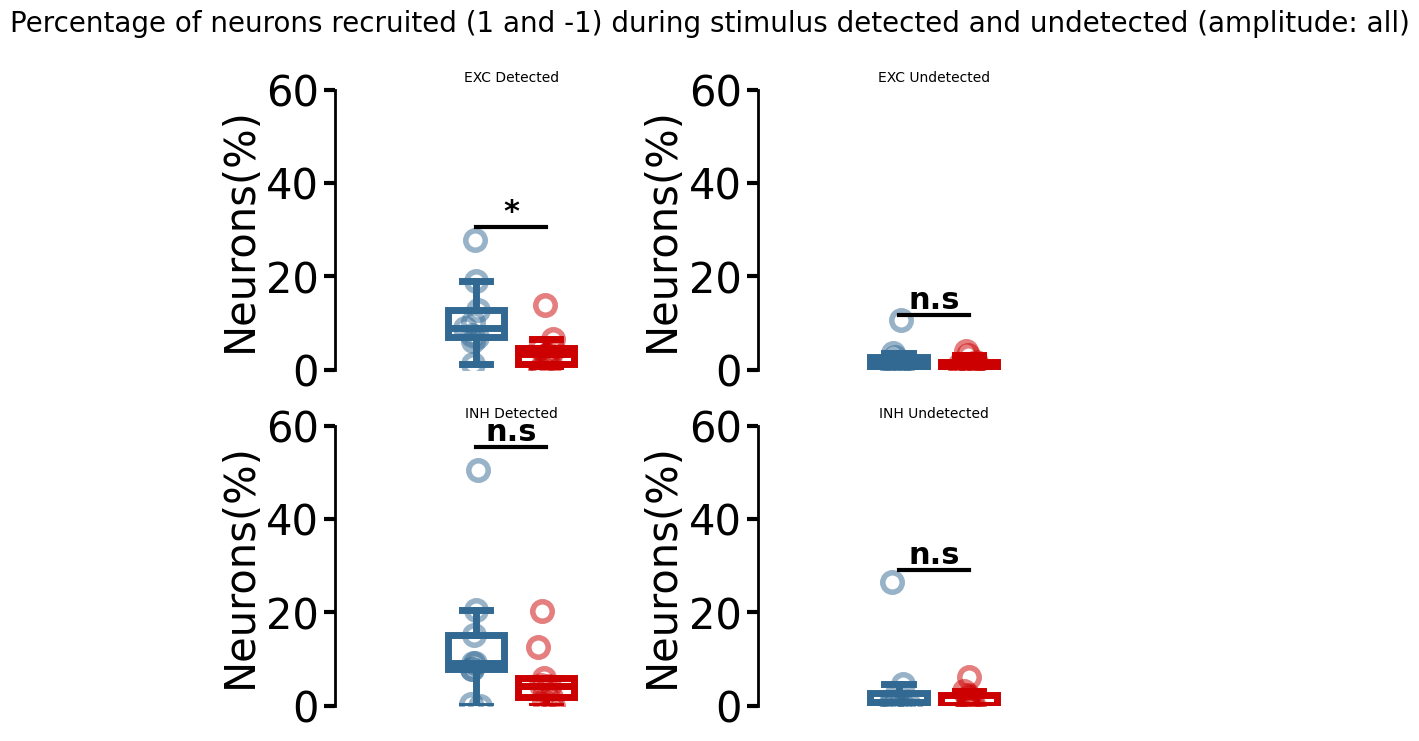

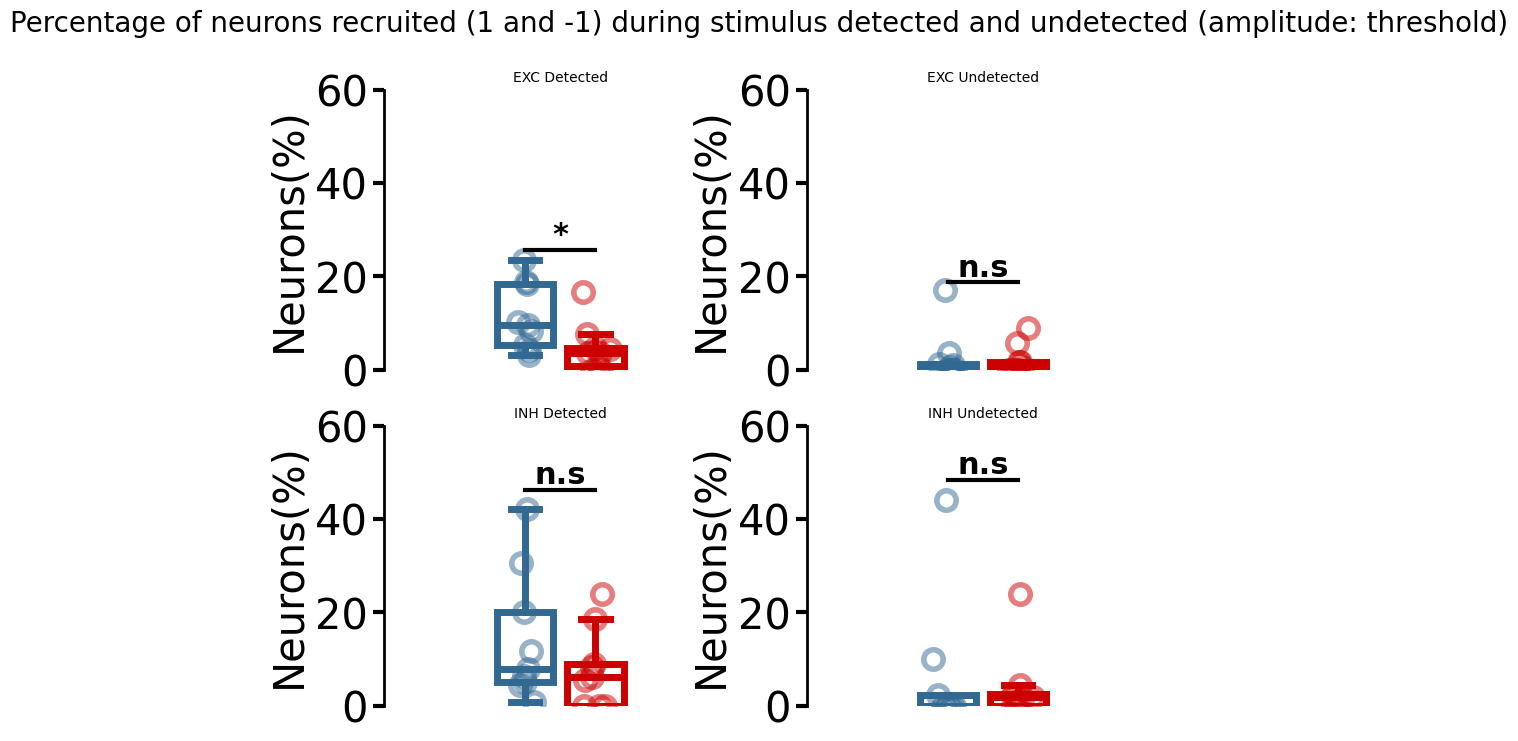

In [5]:
plot_neuron_frac_wt_ko(pattern=0, ko="KO", stim_ampl="all", ylim=[0, 60])
plot_neuron_frac_wt_ko(pattern=0, ko="KO", stim_ampl="threshold", ylim=[0, 60])

## Fraction of neurons activated (1) 


Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9715886255071312, pvalue=0.9079640372756269)
ShapiroResult(statistic=0.6686416491994653, pvalue=0.0006101461881336976)
MannwhitneyuResult(statistic=63.0, pvalue=0.052058768750600205)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.863747723217491, pvalue=0.10529506103779052)
ShapiroResult(statistic=0.8323919329713629, pvalue=0.04749783546042568)
MannwhitneyuResult(statistic=49.0, pvalue=0.4753370978324023)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8397393690521138, pvalue=0.05737013972212317)
ShapiroResult(statistic=0.9158219603123003, pvalue=0.3587729794890124)
LeveneResult(statistic=1.9299254243118633, pvalue=0.1837993595316002)
Equal variances :TtestResult(statistic=1.6321409391753237, pvalue=0.12217226827608905, df=16.0)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8345797836262635, pvalue=0.050251373298421366)
ShapiroResult(statistic=0.730581724482104, pvalue=0.0032

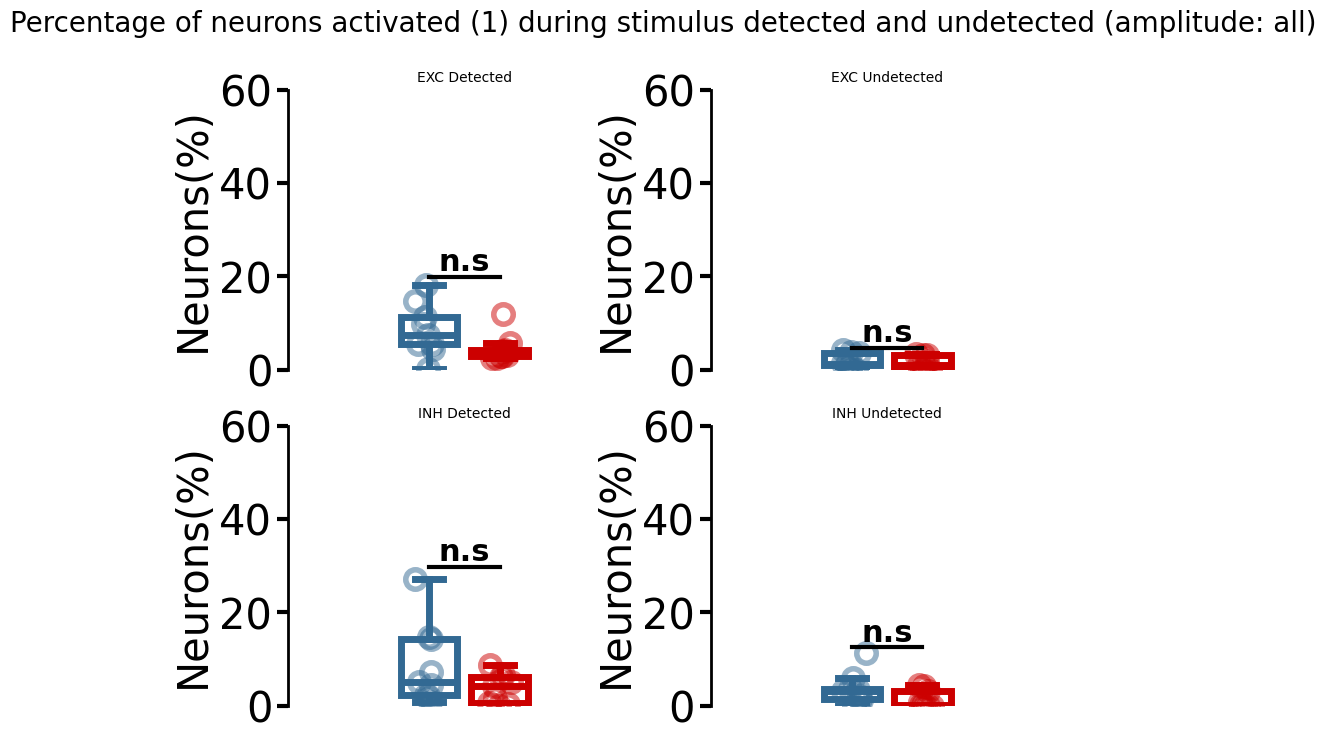

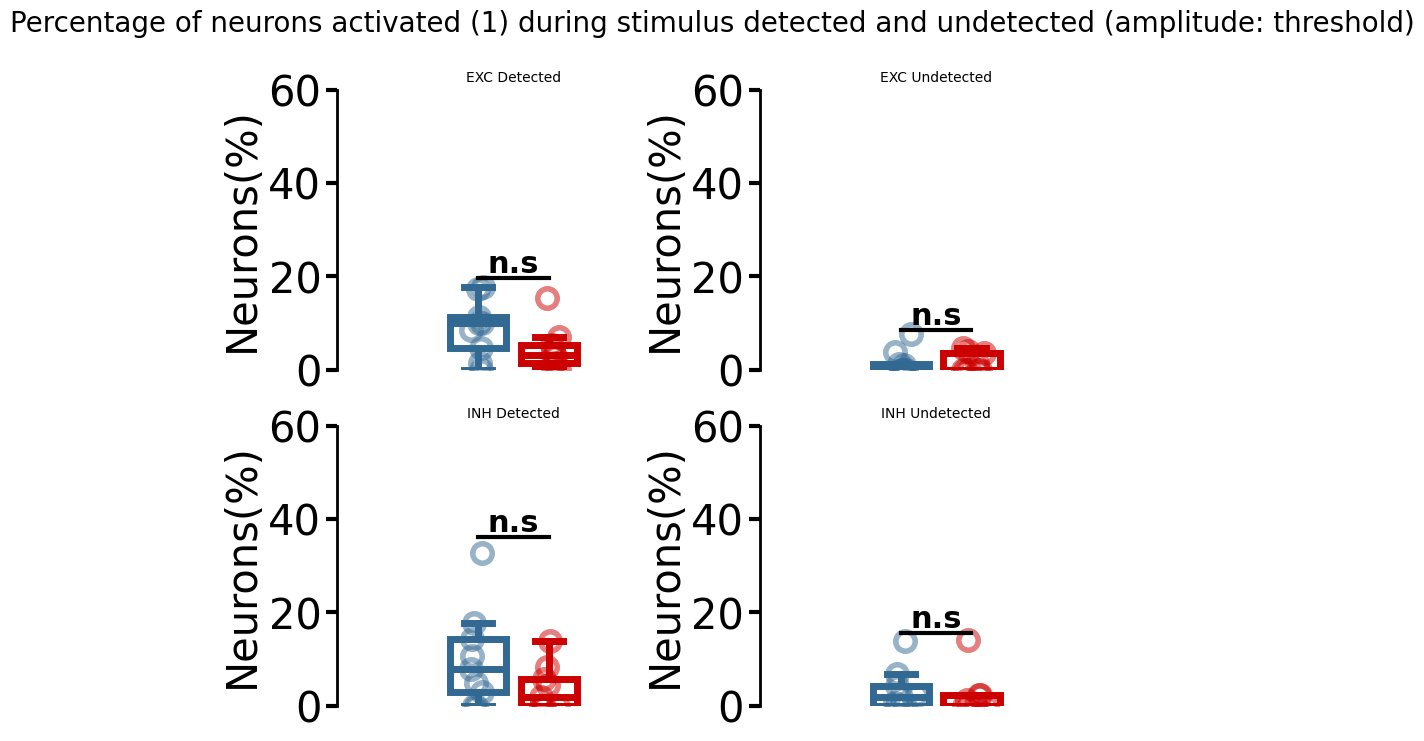

In [6]:
plot_neuron_frac_wt_ko(pattern=1, ko="KO", stim_ampl="all", ylim=[0, 60])
plot_neuron_frac_wt_ko(pattern=1, ko="KO", stim_ampl="threshold", ylim=[0, 60])

## Fraction of neurons inhibited (-1) 

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5697065884454251, pvalue=4.218349212648518e-05)
ShapiroResult(statistic=0.7895786201354852, pvalue=0.015517274588776307)
MannwhitneyuResult(statistic=53.0, pvalue=0.2749917892280068)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.47671476709066385, pvalue=3.4019071837248674e-06)
ShapiroResult(statistic=0.7089375148360371, pvalue=0.0018045812596126395)
MannwhitneyuResult(statistic=45.5, pvalue=0.6626682884253403)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.6033457785090619, pvalue=0.00010473030174722723)
ShapiroResult(statistic=0.6193584757869972, pvalue=0.0001614122306003742)
MannwhitneyuResult(statistic=52.5, pvalue=0.2879749369923187)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.4580979939042771, pvalue=2.053508891992133e-06)
ShapiroResult(statistic=0.5455473722997443, pvalue=2.1943697620830234e-05)
MannwhitneyuResult(statistic=44.0, pvalue=0.7374318596140068)
Boxplot p

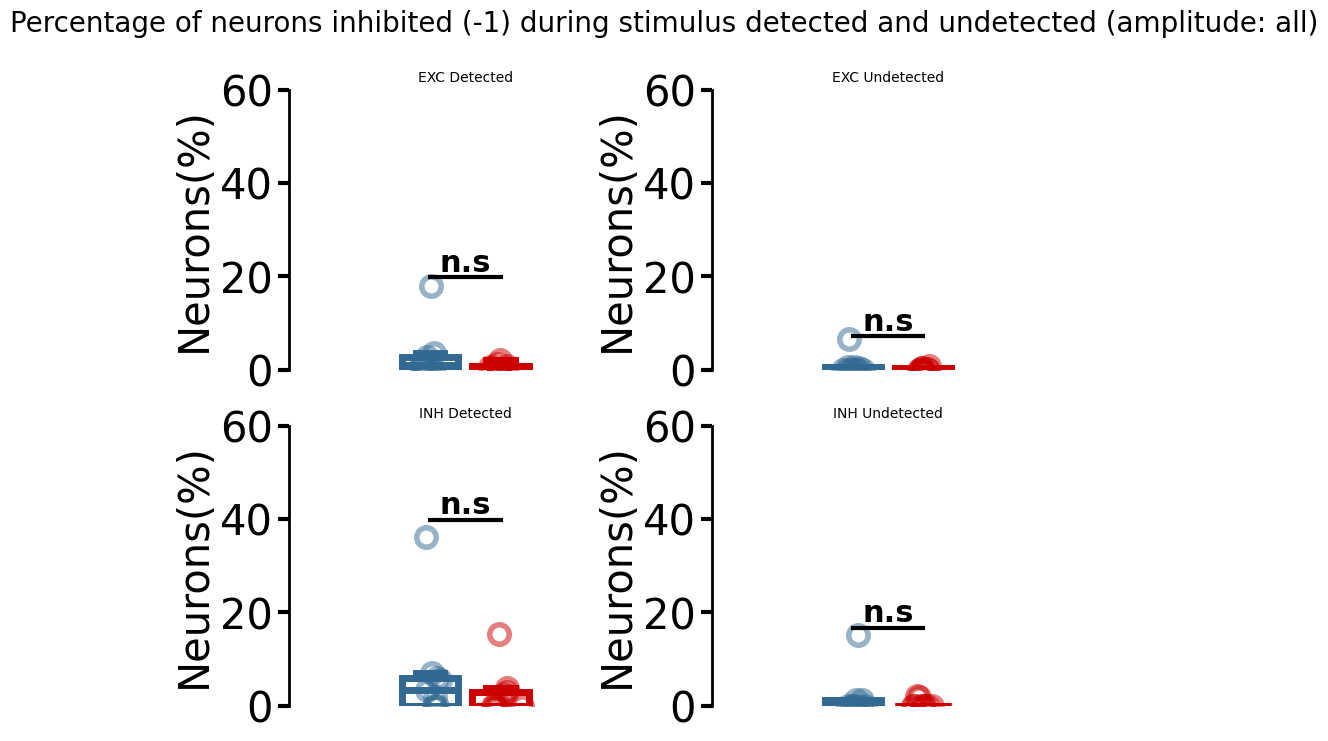

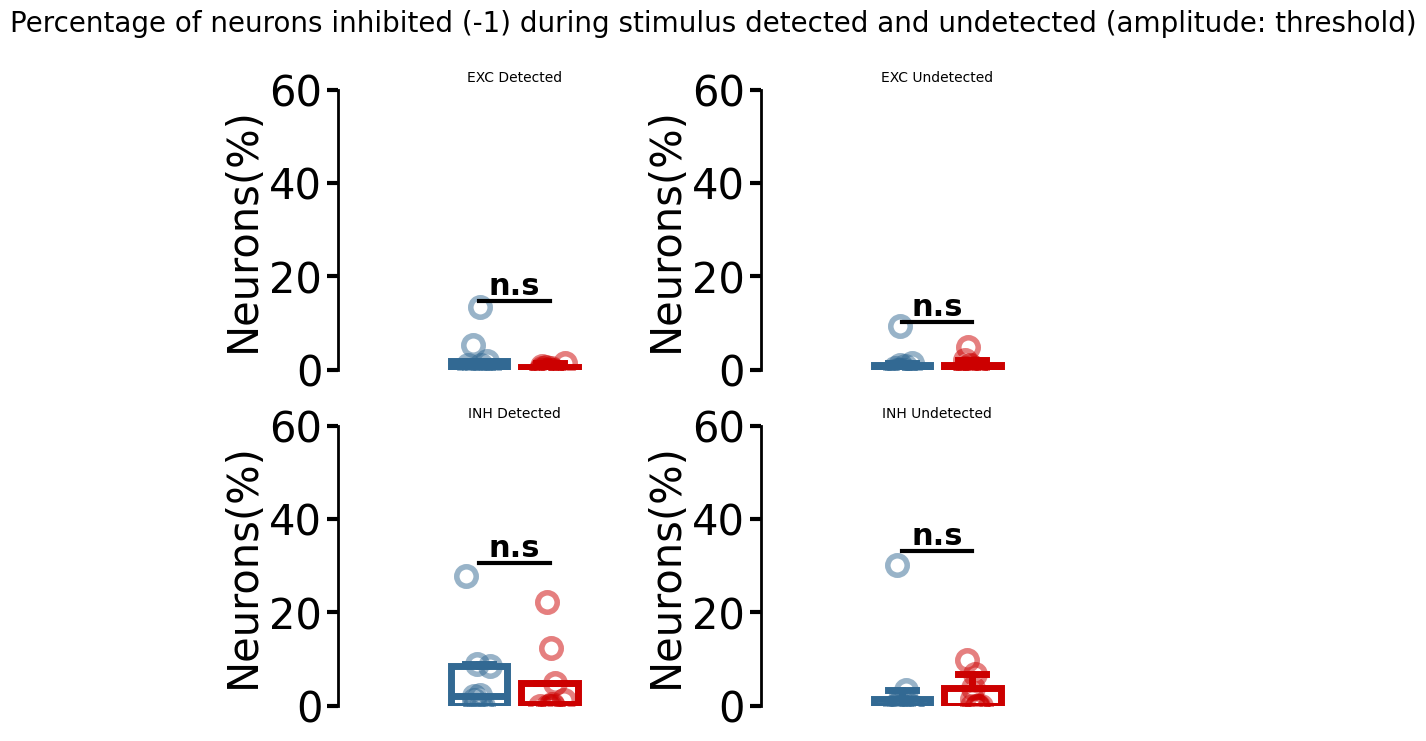

In [7]:
plot_neuron_frac_wt_ko(pattern=-1, ko="KO", stim_ampl="all", ylim=[0, 50])
plot_neuron_frac_wt_ko(pattern=-1, ko="KO", stim_ampl="threshold", ylim=[0, 50])

# Comparison WT vs Ko-Hypo

## Fraction of neurons recruited ( 1 and -1) 


Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8963662266692436, pvalue=0.23168374014698145)
ShapiroResult(statistic=0.8660045074275656, pvalue=0.17120545790456587)
LeveneResult(statistic=0.8148700384395667, pvalue=0.38195339825932806)
Equal variances :TtestResult(statistic=1.9321997464460925, pvalue=0.07382774403281764, df=14.0)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7021723577219326, pvalue=0.0015046081491658665)
ShapiroResult(statistic=0.8234964912105932, pvalue=0.0693785718777728)
MannwhitneyuResult(statistic=37.0, pvalue=0.5911188975011942)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7616268490155889, pvalue=0.00739245951146654)
ShapiroResult(statistic=0.8700614104218866, pvalue=0.18585759117716477)
MannwhitneyuResult(statistic=41.5, pvalue=0.3142583667221204)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5276301238642018, pvalue=1.3511595234788798e-05)
ShapiroResult(statistic=0.7733777220361945, pvalue=0.

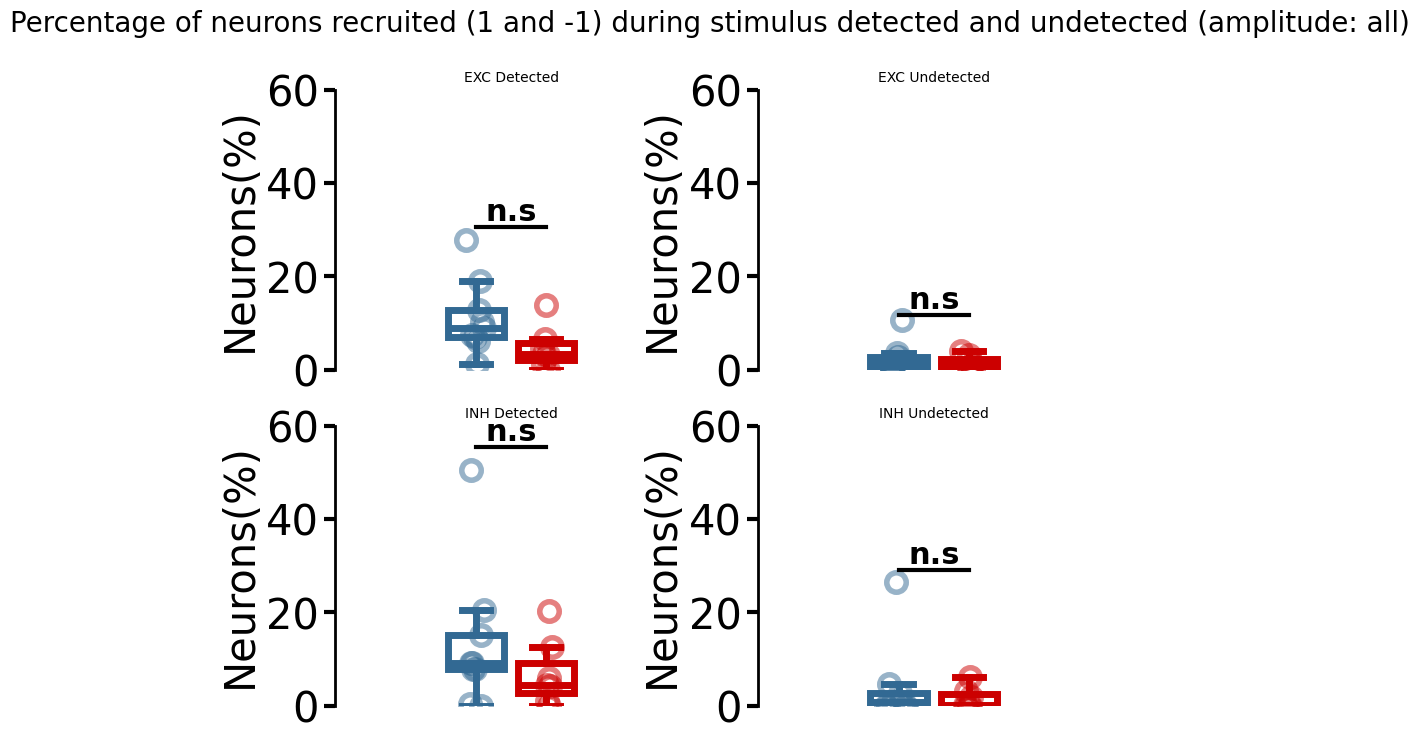

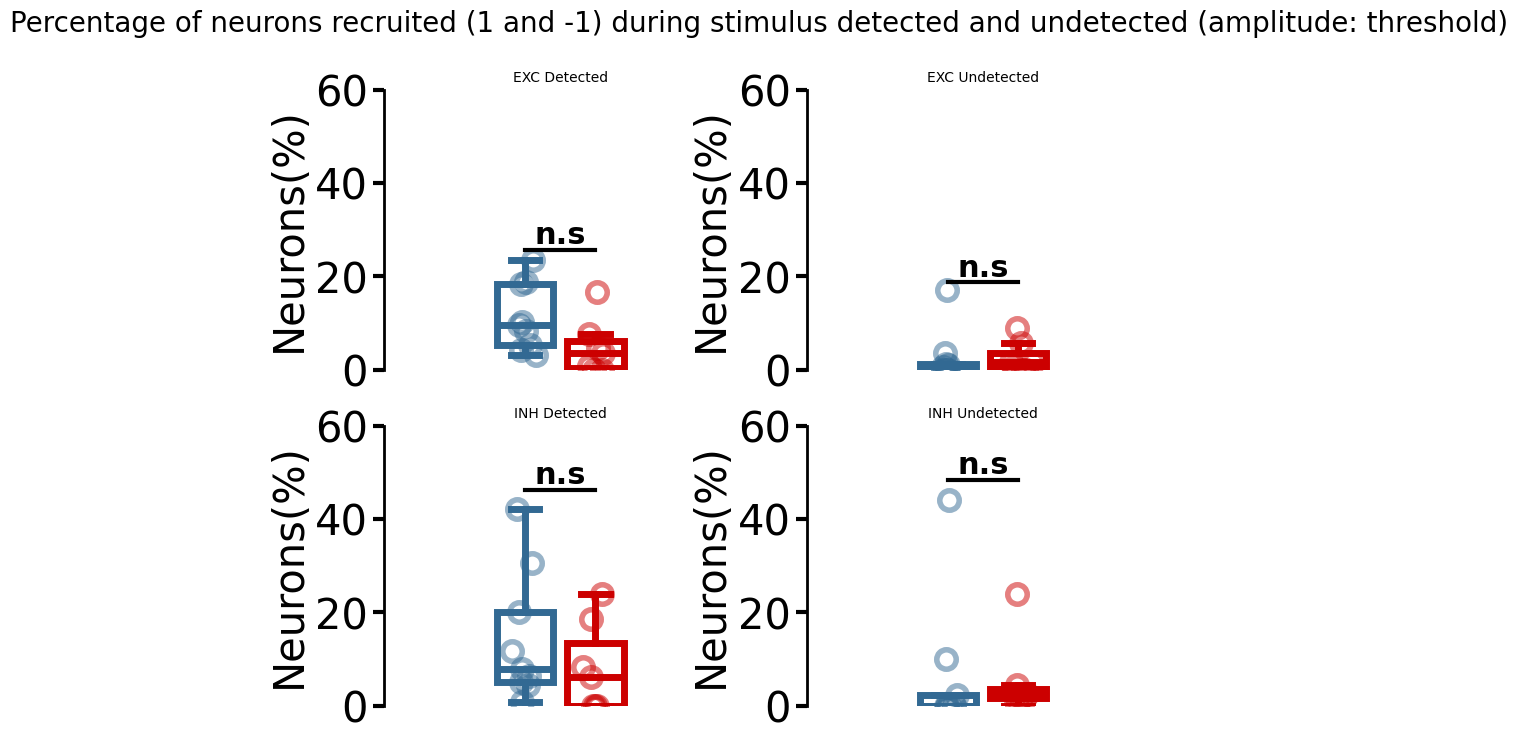

In [8]:
plot_neuron_frac_wt_ko(pattern=0, ko="KO-Hypo", stim_ampl="all", ylim=[0, 60])
plot_neuron_frac_wt_ko(pattern=0, ko="KO-Hypo", stim_ampl="threshold", ylim=[0, 60])
# from matplotlib.ticker import MaxNLocator
# axs[0,0].yaxis.set_major_locator(MaxNLocator(integer=True))
# axs[1,1].yaxis.set_major_locator(MaxNLocator(integer=True))

## Fraction of neurons activated (1) 

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9715886255071312, pvalue=0.9079640372756269)
ShapiroResult(statistic=0.7312187702483861, pvalue=0.008043278218586483)
MannwhitneyuResult(statistic=47.0, pvalue=0.11416083916083916)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.863747723217491, pvalue=0.10529506103779052)
ShapiroResult(statistic=0.810150556870984, pvalue=0.051542279826455324)
LeveneResult(statistic=0.03773484989452005, pvalue=0.8487670378326845)
Equal variances :TtestResult(statistic=0.31436465111943246, pvalue=0.7578799866071799, df=14.0)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8397393690521138, pvalue=0.05737013972212317)
ShapiroResult(statistic=0.9679615092664401, pvalue=0.8833897122063161)
LeveneResult(statistic=1.9328775492843875, pvalue=0.1861524472416812)
Equal variances :TtestResult(statistic=1.1778814514681955, pvalue=0.2584790556259059, df=14.0)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8

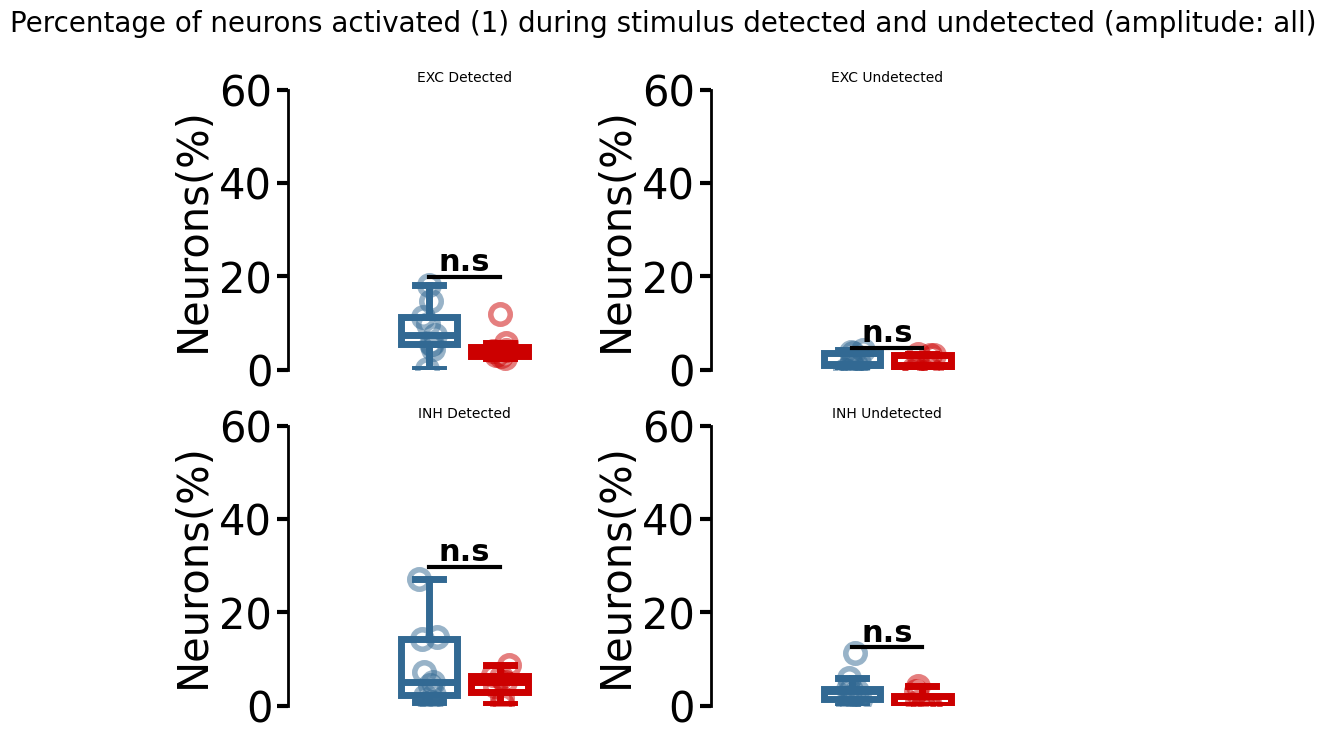

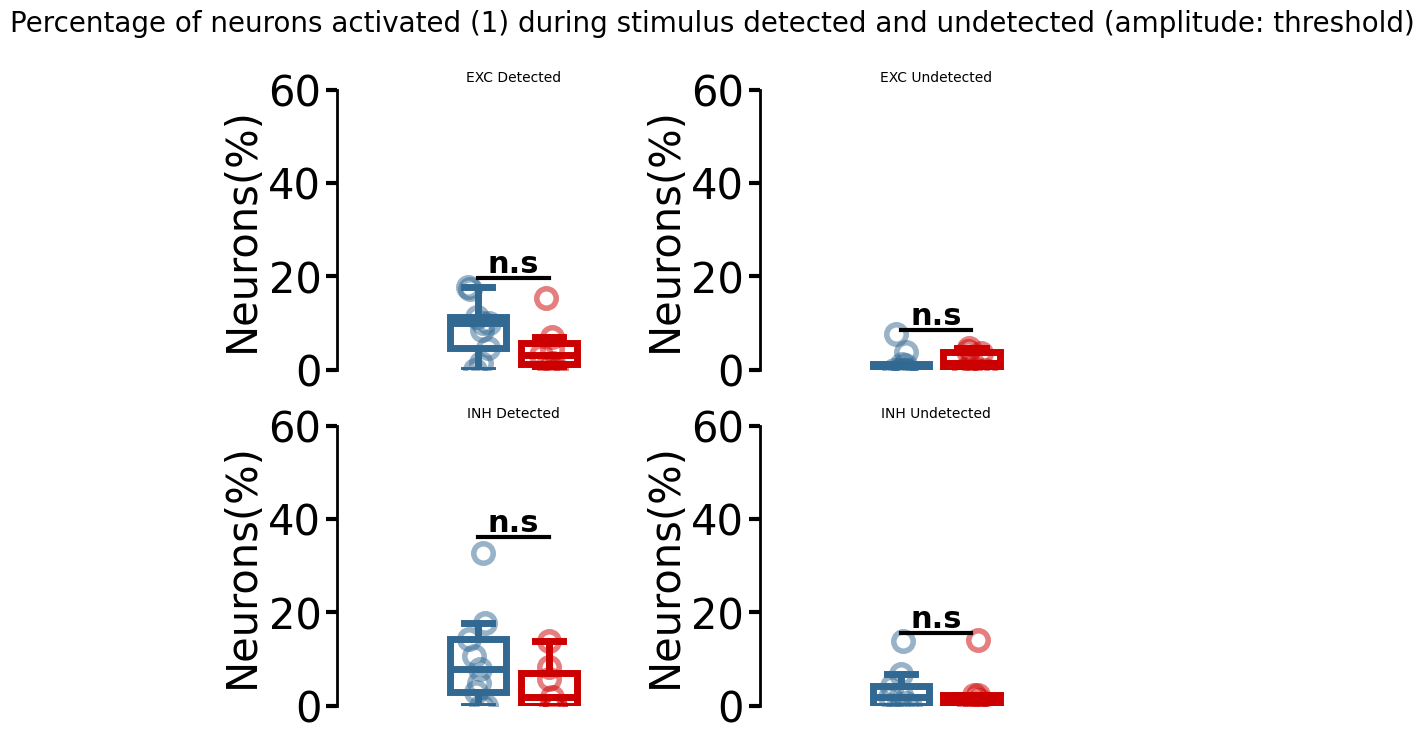

In [9]:
plot_neuron_frac_wt_ko(pattern=1, ko="KO-Hypo", stim_ampl="all", ylim=[0, 60])
plot_neuron_frac_wt_ko(pattern=1, ko="KO-Hypo", stim_ampl="threshold", ylim=[0, 60])

## Fraction of neurons inhibited (-1) 

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5697065884454251, pvalue=4.218349212648518e-05)
ShapiroResult(statistic=0.7549016184047022, pvalue=0.014271663635000379)
MannwhitneyuResult(statistic=42.5, pvalue=0.2537888660005908)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.47671476709066385, pvalue=3.4019071837248674e-06)
ShapiroResult(statistic=0.7941756942214614, pvalue=0.03585730503511788)
MannwhitneyuResult(statistic=32.5, pvalue=0.9549177065523541)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.6033457785090619, pvalue=0.00010473030174722723)
ShapiroResult(statistic=0.5817495617994556, pvalue=0.00016557480473705546)
MannwhitneyuResult(statistic=42.5, pvalue=0.23515669100197867)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.4580979939042771, pvalue=2.053508891992133e-06)
ShapiroResult(statistic=0.6135252153514845, pvalue=0.00039190819724697315)
MannwhitneyuResult(statistic=32.0, pvalue=1.0)
Boxplot plotting.
--- Ne

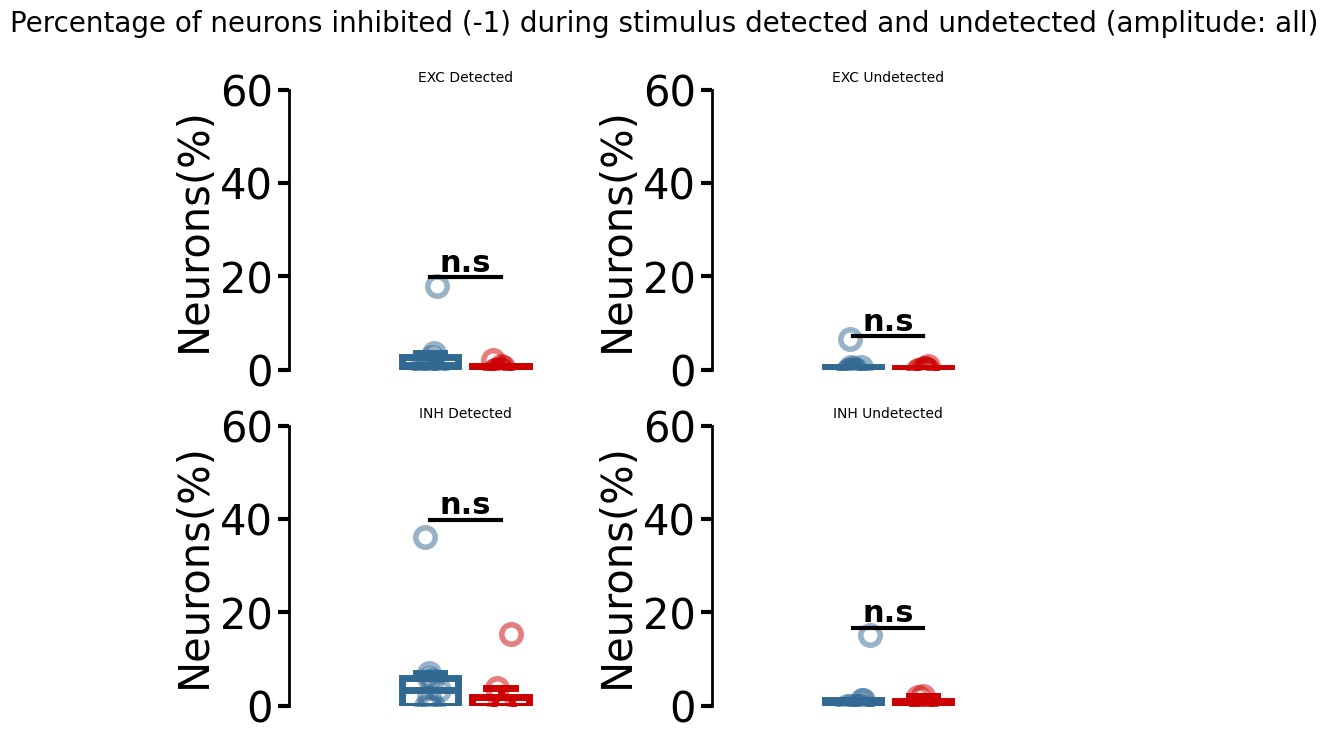

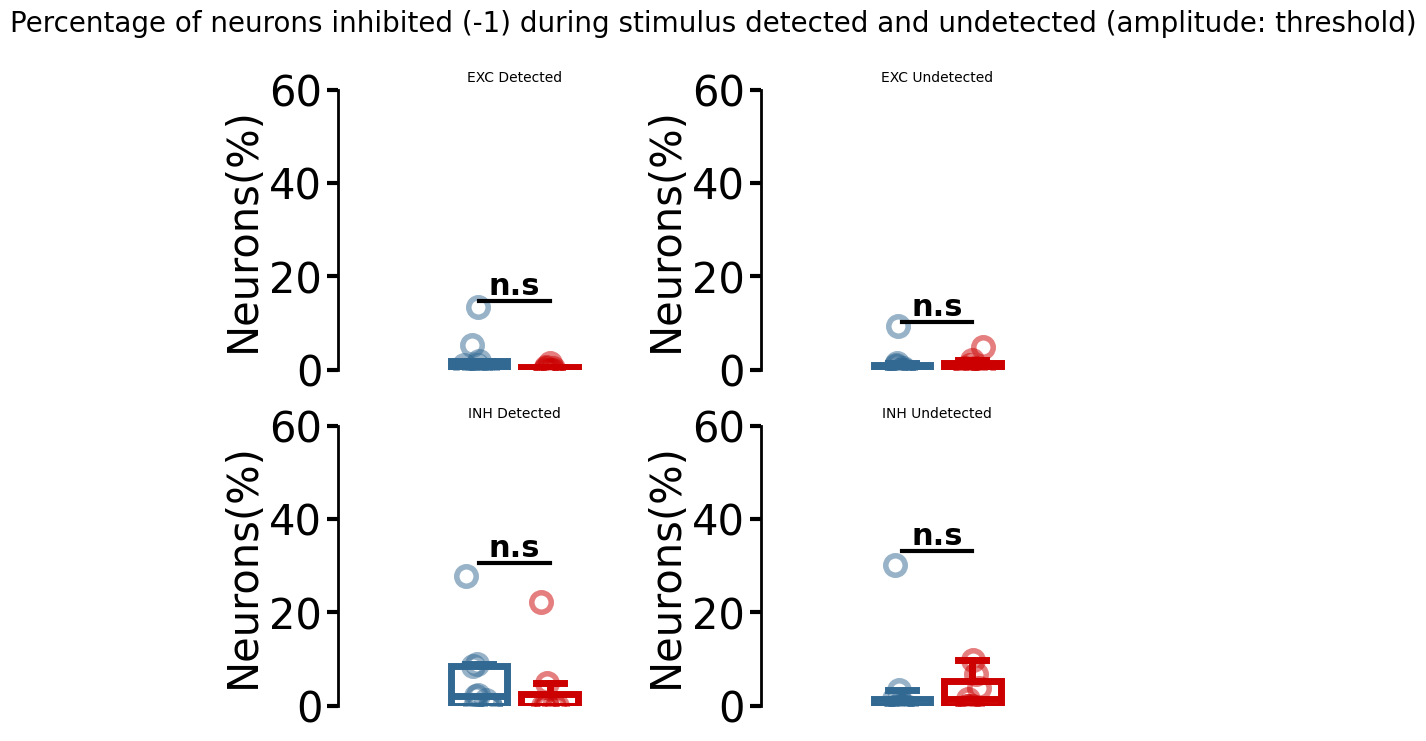

In [10]:
plot_neuron_frac_wt_ko(pattern=-1, ko="KO-Hypo", stim_ampl="all", ylim=[0, 50])
plot_neuron_frac_wt_ko(pattern=-1, ko="KO-Hypo", stim_ampl="threshold", ylim=[0, 50])

# Comparison group det vs group undet


## Fraction of neurons recruited (1 and -1)

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8963662266692436, pvalue=0.23168374014698145)
ShapiroResult(statistic=0.7021723577219326, pvalue=0.0015046081491658665)
WilcoxonResult(statistic=0.0, pvalue=0.00390625)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8660045074275656, pvalue=0.17120545790456587)
ShapiroResult(statistic=0.8234964912105932, pvalue=0.0693785718777728)
TtestResult(statistic=2.3845153127347594, pvalue=0.05443183415299142, df=6)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7616268490155889, pvalue=0.00739245951146654)
ShapiroResult(statistic=0.5276301238642018, pvalue=1.3511595234788798e-05)
WilcoxonResult(statistic=2.0, pvalue=0.01171875)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8700614104218866, pvalue=0.18585759117716477)
ShapiroResult(statistic=0.7733777220361945, pvalue=0.022121454494750274)
WilcoxonResult(statistic=3.0, pvalue=0.078125)


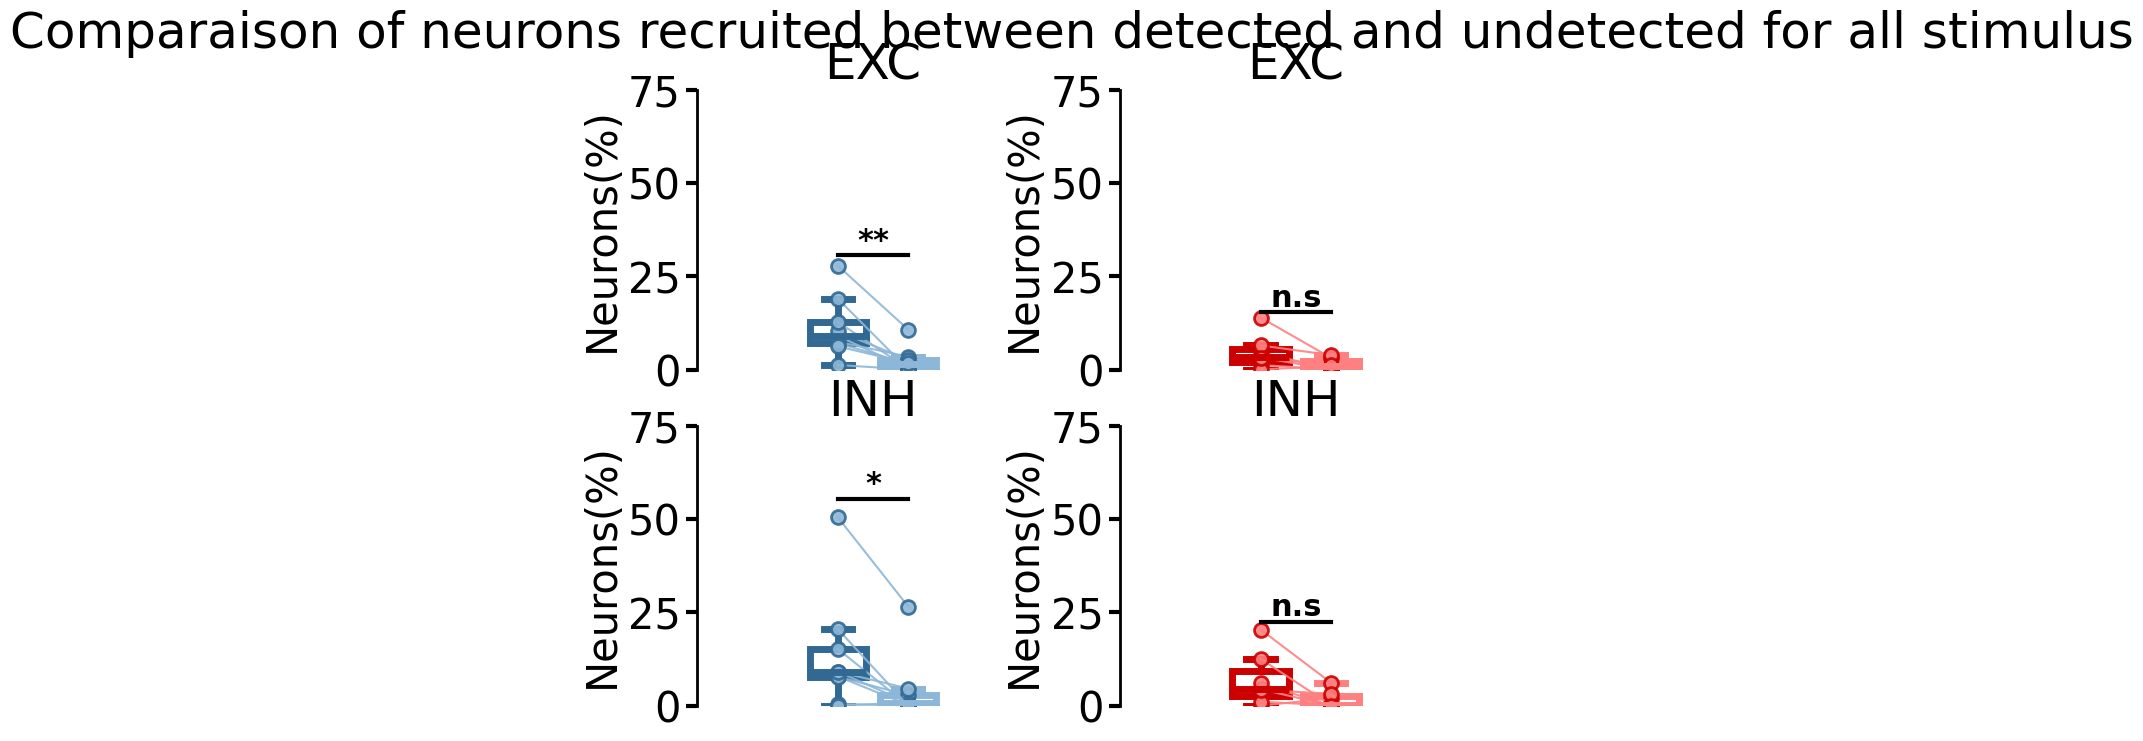

In [11]:
fig, axs = plt.subplots(2,2,figsize=(10,8))
for i, type in enumerate(["EXC", "INH"]):
    wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=0, n_type=type, ko="KO-Hypo", stim_ampl="all")
    ppt.paired_boxplot(axs[i,0], wt_det,wt_undet,"Neurons(%)", type,ylim=[0,70],colors=[ppt.wt_color, ppt.light_wt_color])
    ppt.paired_boxplot(axs[i,1], ko_det,ko_undet,"Neurons(%)", type,ylim=[0,70])
    fig.suptitle("Comparaison of neurons recruited between detected and undetected for all stimulus")

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.898601689518662, pvalue=0.24400574650037898)
ShapiroResult(statistic=0.5350228257427809, pvalue=1.6504897481236253e-05)
WilcoxonResult(statistic=0.0, pvalue=0.00390625)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8229133725772506, pvalue=0.06849182386073126)
ShapiroResult(statistic=0.8032777125632116, pvalue=0.044132918809213106)
WilcoxonResult(statistic=4.0, pvalue=0.109375)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8494479703347717, pvalue=0.07348490759825994)
ShapiroResult(statistic=0.5193093798875208, pvalue=1.0786292317751048e-05)
WilcoxonResult(statistic=6.0, pvalue=0.0546875)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8398379625745775, pvalue=0.09901307318034559)
ShapiroResult(statistic=0.6050717519343698, pvalue=0.00031220896490988253)
WilcoxonResult(statistic=6.0, pvalue=0.3454475304692257)


C:\Users\eFrick\PycharmProjects\Percephone\venv2\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\eFrick\PycharmProjects\Percephone\venv2\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Sample size too small for normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


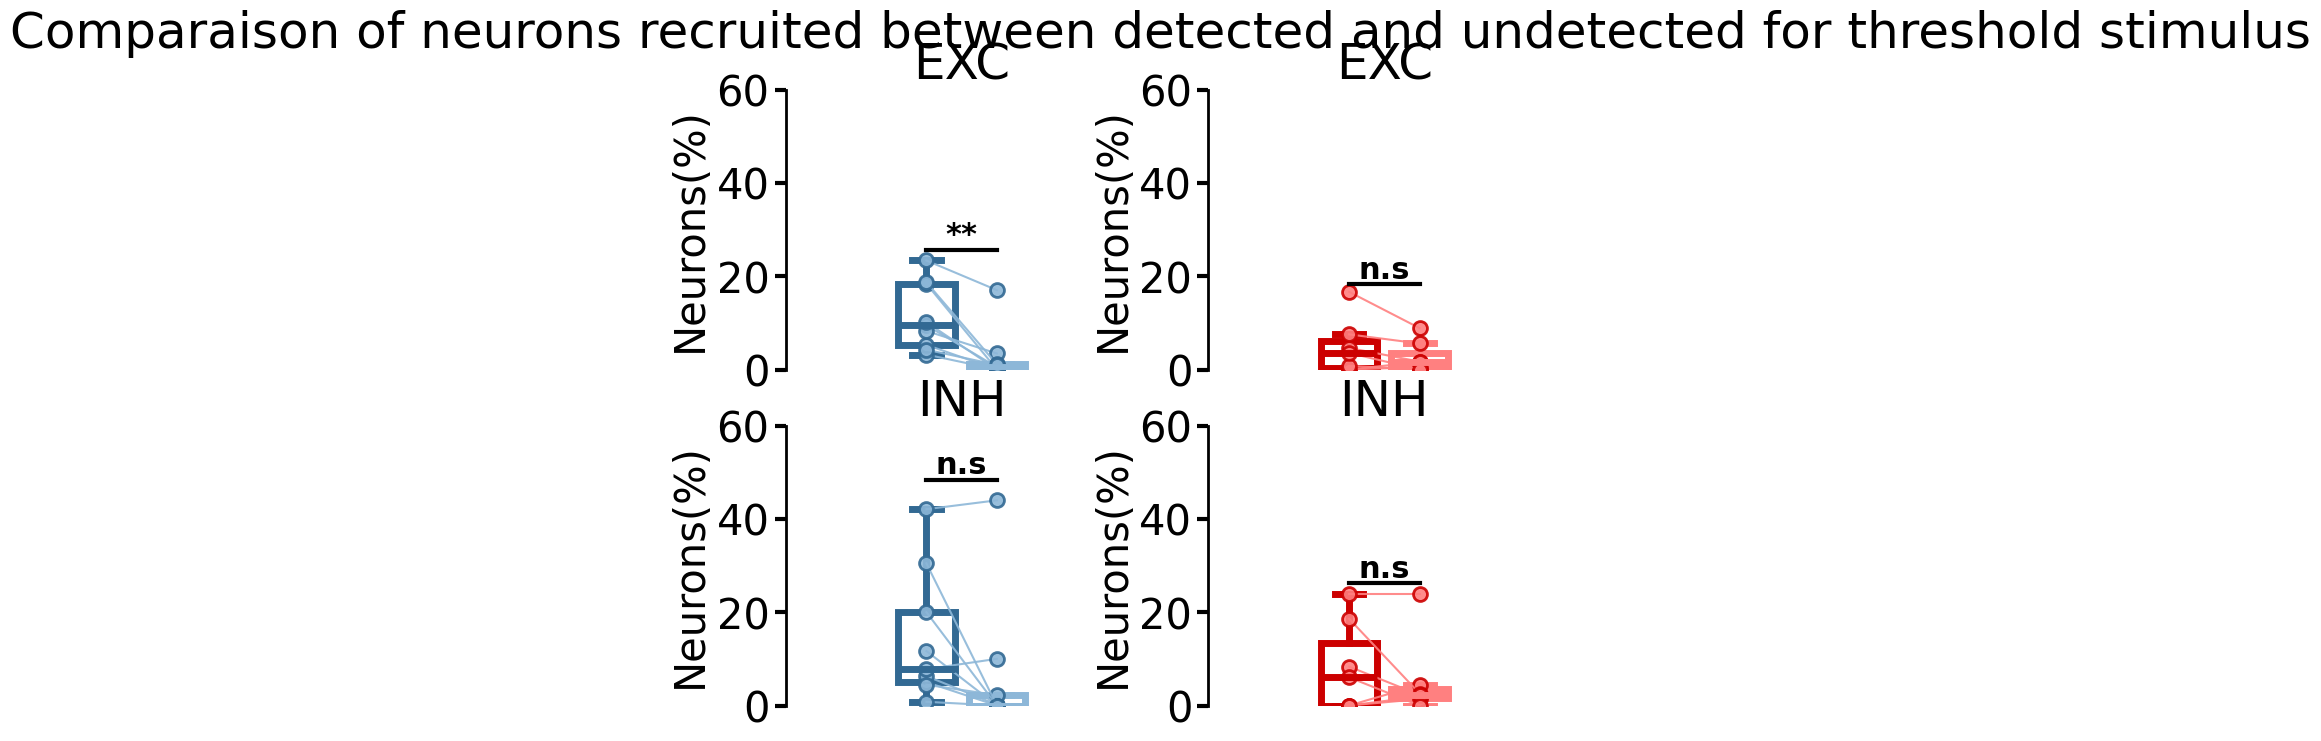

In [12]:
fig, axs = plt.subplots(2,2,figsize=(10,8))
for i, type in enumerate(["EXC", "INH"]):
    wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=0, n_type=type, ko="KO-Hypo", stim_ampl="threshold")
    ppt.paired_boxplot(axs[i,0], wt_det,wt_undet,"Neurons(%)", type,ylim=[0,60],colors=[ppt.wt_color, ppt.light_wt_color])
    ppt.paired_boxplot(axs[i,1], ko_det,ko_undet,"Neurons(%)", type,ylim=[0,60])
    fig.suptitle("Comparaison of neurons recruited between detected and undetected for threshold stimulus")

## Fraction of neurons activated(1)

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9715886255071312, pvalue=0.9079640372756269)
ShapiroResult(statistic=0.863747723217491, pvalue=0.10529506103779052)
TtestResult(statistic=3.816432083583067, pvalue=0.0051156101119442425, df=8)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7312187702483861, pvalue=0.008043278218586483)
ShapiroResult(statistic=0.810150556870984, pvalue=0.051542279826455324)
WilcoxonResult(statistic=1.0, pvalue=0.03125)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8397393690521138, pvalue=0.05737013972212317)
ShapiroResult(statistic=0.8345797836262635, pvalue=0.050251373298421366)
TtestResult(statistic=1.8230033642301497, pvalue=0.10576458349700633, df=8)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9679615092664401, pvalue=0.8833897122063161)
ShapiroResult(statistic=0.7350204561287395, pvalue=0.008826284312321865)
WilcoxonResult(statistic=0.0, pvalue=0.015625)


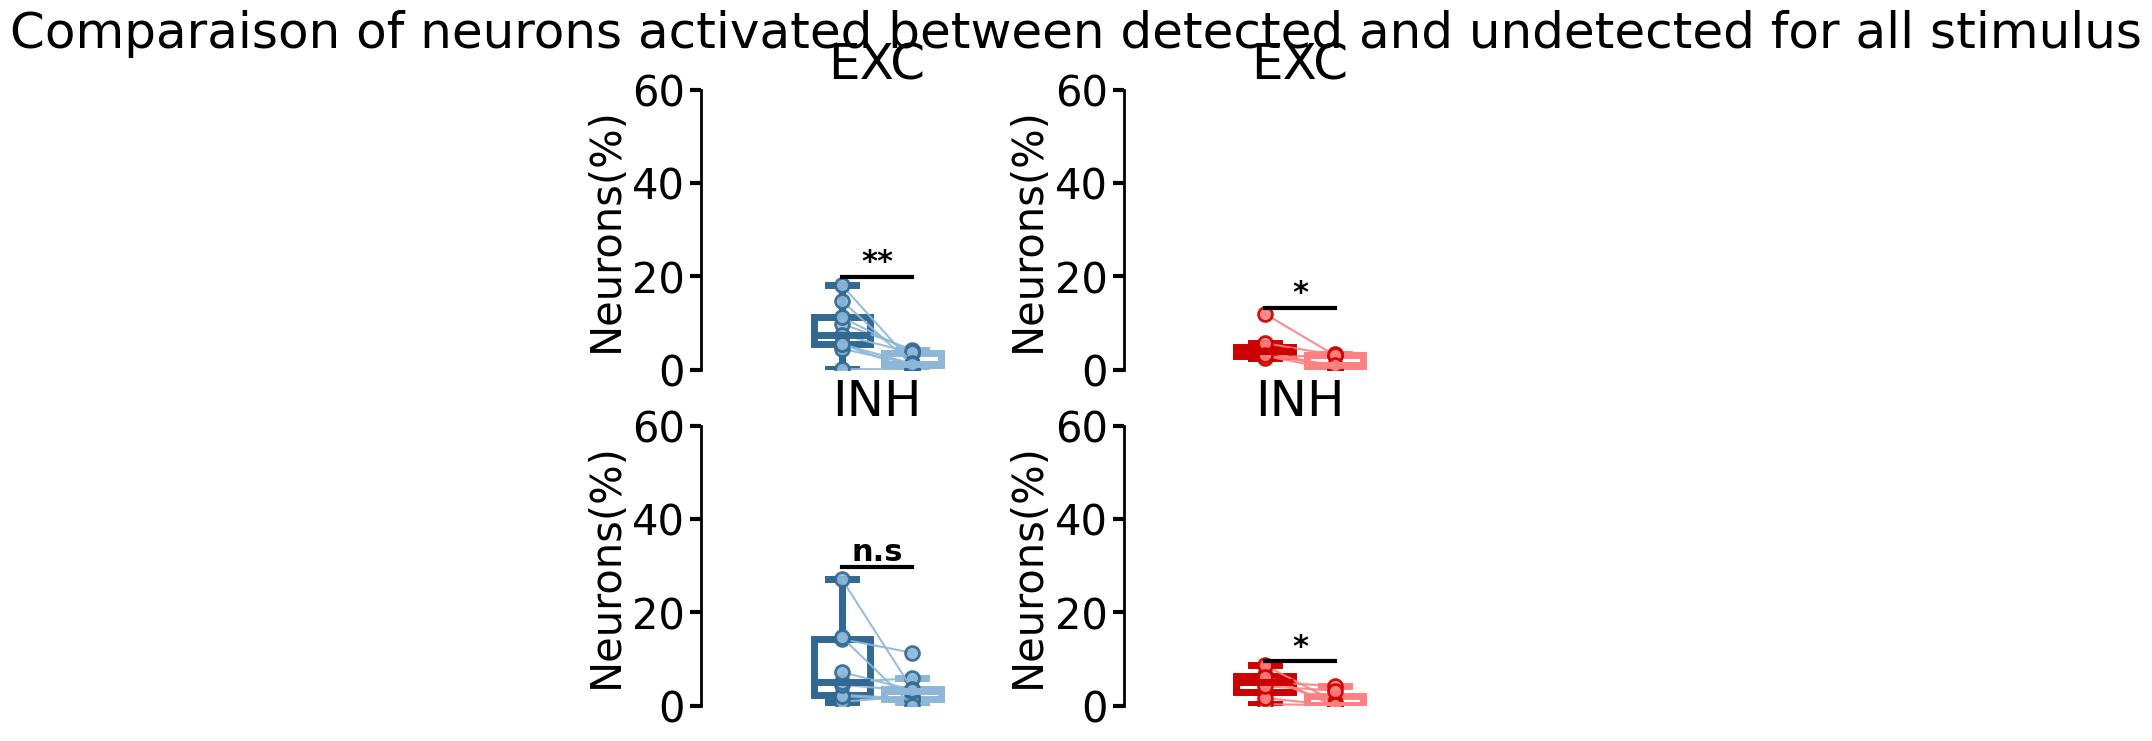

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, type in enumerate(["EXC", "INH"]):
    wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=1, n_type=type, ko="KO-Hypo", stim_ampl="all")
    ppt.paired_boxplot(axs[i, 0], wt_det, wt_undet, "Neurons(%)", type, ylim=[0, 50],
                       colors=[ppt.wt_color, ppt.light_wt_color])
    ppt.paired_boxplot(axs[i, 1], ko_det, ko_undet, "Neurons(%)", type, ylim=[0, 50])
    fig.suptitle("Comparaison of neurons activated between detected and undetected for all stimulus")

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9367255938772927, pvalue=0.5478843108277514)
ShapiroResult(statistic=0.6695067073247711, pvalue=0.0006245372703629127)
WilcoxonResult(statistic=0.0, pvalue=0.011718685599768628)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.828697635421719, pvalue=0.0777739376421018)
ShapiroResult(statistic=0.821677353120557, pvalue=0.06664700906349637)
TtestResult(statistic=1.6520471200882274, pvalue=0.149613334895039, df=6)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8821201073293736, pvalue=0.16527621429566736)
ShapiroResult(statistic=0.7654430860372927, pvalue=0.008182908376587224)
WilcoxonResult(statistic=4.0, pvalue=0.0499499764547464)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8350847318695135, pvalue=0.08937026098000388)
ShapiroResult(statistic=0.6217404046579019, pvalue=0.00048817720360898857)
WilcoxonResult(statistic=5.0, pvalue=0.5001842570707944)


C:\Users\eFrick\PycharmProjects\Percephone\venv2\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\eFrick\PycharmProjects\Percephone\venv2\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Sample size too small for normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\eFrick\PycharmProjects\Percephone\venv2\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\eFrick\PycharmProjects\Percephone\venv2\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Sample size too small for normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\eFrick\PycharmProjects\Percephone\venv2\Lib\site-packages\scipy\s

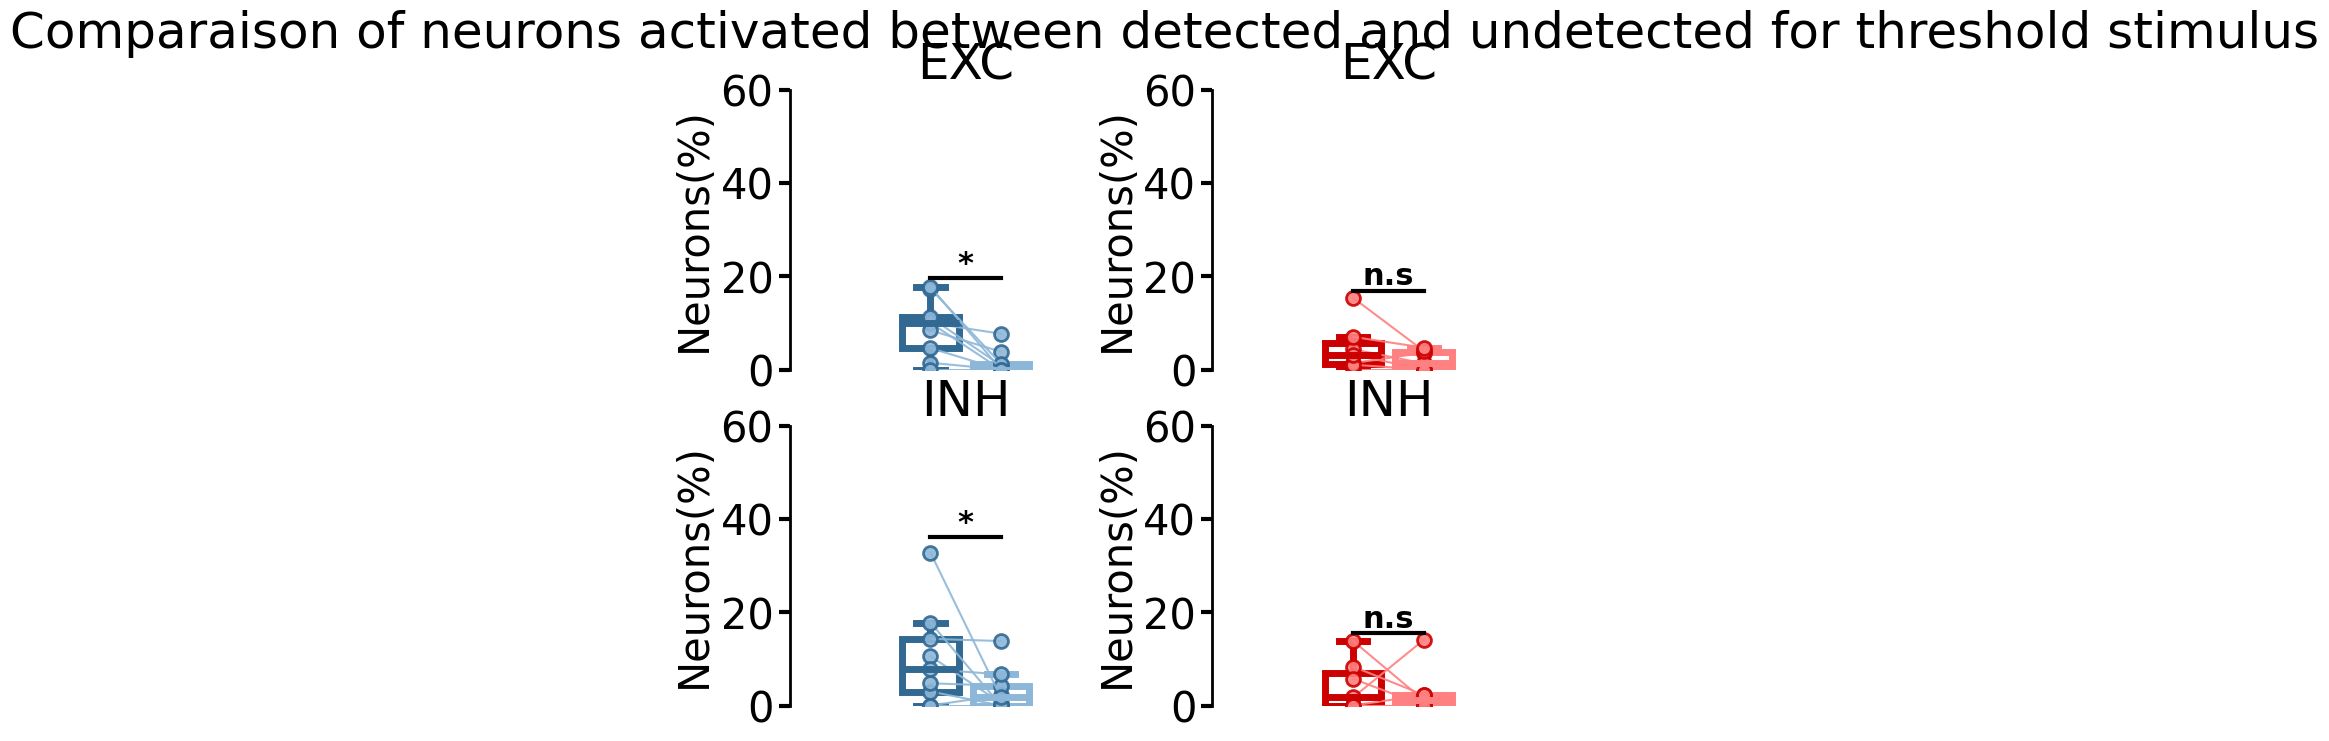

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, type in enumerate(["EXC", "INH"]):
    wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=1, n_type=type, ko="KO-Hypo", stim_ampl="threshold")
    ppt.paired_boxplot(axs[i, 0], wt_det, wt_undet, "Neurons(%)", type, ylim=[0, 50],
                       colors=[ppt.wt_color, ppt.light_wt_color])
    ppt.paired_boxplot(axs[i, 1], ko_det, ko_undet, "Neurons(%)", type, ylim=[0, 50])
    fig.suptitle("Comparaison of neurons activated between detected and undetected for threshold stimulus")

## Fraction of neurons inhibited (-1)

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5697065884454251, pvalue=4.218349212648518e-05)
ShapiroResult(statistic=0.47671476709066385, pvalue=3.4019071837248674e-06)
WilcoxonResult(statistic=0.0, pvalue=0.027707849358079864)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7549016184047022, pvalue=0.014271663635000379)
ShapiroResult(statistic=0.7941756942214614, pvalue=0.03585730503511788)
WilcoxonResult(statistic=2.0, pvalue=0.27332167829229814)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.6033457785090619, pvalue=0.00010473030174722723)
ShapiroResult(statistic=0.4580979939042771, pvalue=2.053508891992133e-06)
WilcoxonResult(statistic=0.0, pvalue=0.027707849358079864)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5817495617994556, pvalue=0.00016557480473705546)
ShapiroResult(statistic=0.6135252153514845, pvalue=0.00039190819724697315)
WilcoxonResult(statistic=1.0, pvalue=0.28504940740261275)


C:\Users\eFrick\PycharmProjects\Percephone\venv2\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\eFrick\PycharmProjects\Percephone\venv2\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Sample size too small for normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\eFrick\PycharmProjects\Percephone\venv2\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\eFrick\PycharmProjects\Percephone\venv2\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Sample size too small for normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\eFrick\PycharmProjects\Percephone\venv2\Lib\site-packages\scipy\s

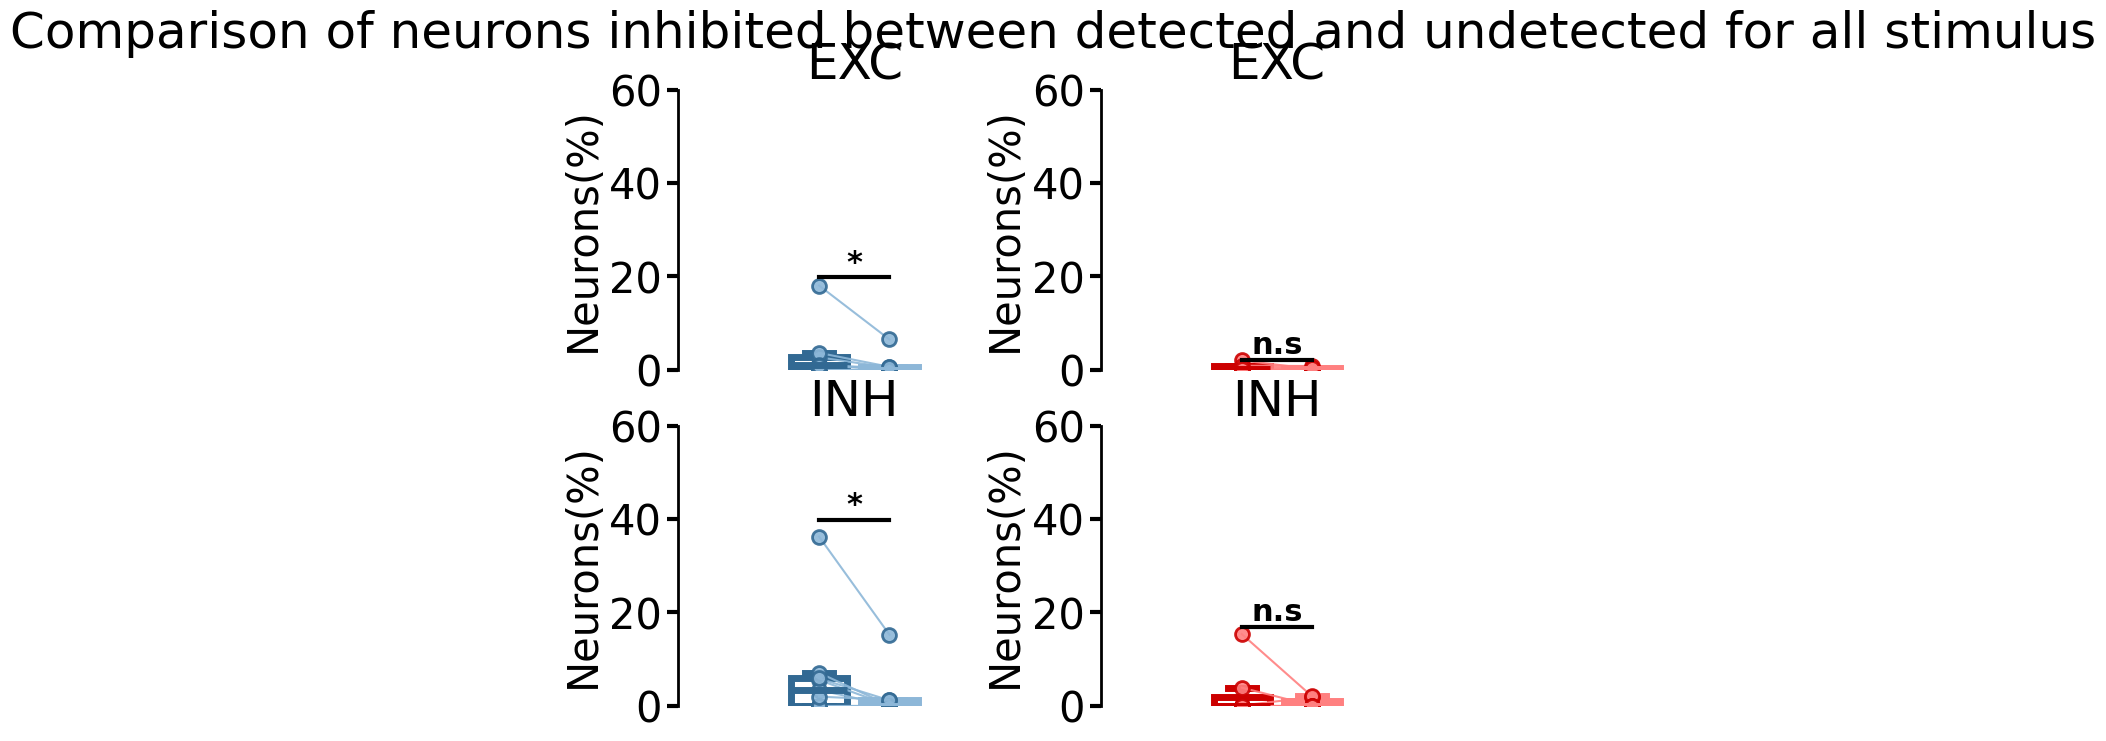

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, type in enumerate(["EXC", "INH"]):
    wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=-1, n_type=type, ko="KO-Hypo", stim_ampl="all")
    ppt.paired_boxplot(axs[i, 0], wt_det, wt_undet, "Neurons(%)", type, ylim=[0, 60],
                       colors=[ppt.wt_color, ppt.light_wt_color])
    ppt.paired_boxplot(axs[i, 1], ko_det, ko_undet, "Neurons(%)", type, ylim=[0, 60])
    fig.suptitle("Comparison of neurons inhibited between detected and undetected for all stimulus")

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.6451458048832857, pvalue=0.0003237909880116198)
ShapiroResult(statistic=0.5379871097866749, pvalue=1.7883631548138785e-05)
WilcoxonResult(statistic=6.0, pvalue=0.17629637444051116)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8046759180421498, pvalue=0.04555376081405441)
ShapiroResult(statistic=0.7442778203651381, pvalue=0.011051946781549011)
WilcoxonResult(statistic=1.0, pvalue=0.07961580146011343)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.6798300187894497, pvalue=0.0008247799532188891)
ShapiroResult(statistic=0.4677762997058612, pvalue=2.669814462162398e-06)
WilcoxonResult(statistic=9.0, pvalue=0.39802471950693785)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5739080192913607, pvalue=0.00013346803172028057)
ShapiroResult(statistic=0.8354009762068623, pvalue=0.08998393846573428)
WilcoxonResult(statistic=7.0, pvalue=0.892738400944348)


C:\Users\eFrick\PycharmProjects\Percephone\venv2\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\eFrick\PycharmProjects\Percephone\venv2\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Sample size too small for normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\eFrick\PycharmProjects\Percephone\venv2\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\eFrick\PycharmProjects\Percephone\venv2\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Sample size too small for normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\eFrick\PycharmProjects\Percephone\venv2\Lib\site-packages\scipy\s

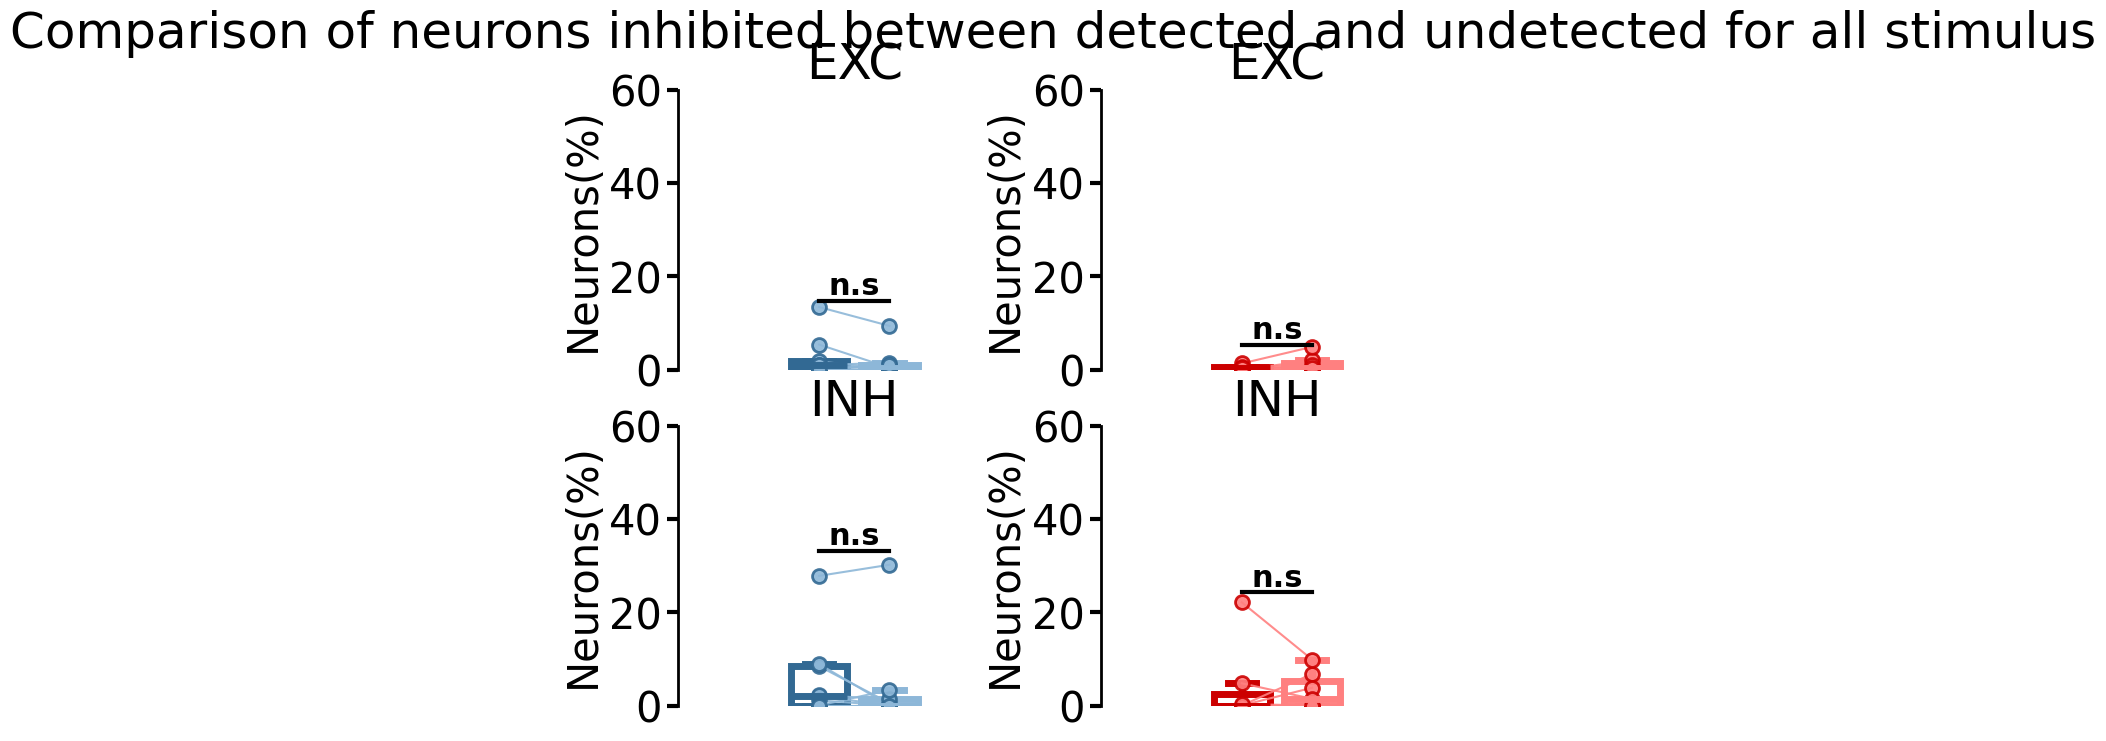

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, type in enumerate(["EXC", "INH"]):
    wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=-1, n_type=type, ko="KO-Hypo", stim_ampl="threshold")
    ppt.paired_boxplot(axs[i, 0], wt_det, wt_undet, "Neurons(%)", type, ylim=[0, 50],
                       colors=[ppt.wt_color, ppt.light_wt_color])
    ppt.paired_boxplot(axs[i, 1], ko_det, ko_undet, "Neurons(%)", type, ylim=[0, 50])
    fig.suptitle("Comparison of neurons inhibited between detected and undetected for all stimulus")

# Responsivity per amplitude line graphs 22/03/2024  

## Graph of activated neurons from amplitude

In [17]:
def plot_neuron_perc_amp(recs, detected_trials=True, undetected_trials=True, signif=False, sign_exc_inh=[[], []]):
    assert detected_trials or undetected_trials
    genotype_dict = {"WT": 0, "KO": 1, "KO-Hypo": 2}
    anova_arr = np.empty((0, 4))
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))
    labels = {"EXC":"Excitatory neurons" , "INH": "Inhibitory neurons"}
    amps = np.arange(2, 14, 2)
    
    for i, n_type in enumerate(["EXC","INH"]):
        wt, ko, ko_hypo = [], [], []
        for rec in recs.values():
            resp_mat = np.array(rec.matrices[n_type]["Responsivity"])
            resp_p = []
            # The no-go trials are used to normalized
            trials_no_go = resp_mat[:, rec.stim_ampl_filter(stim_ampl=[0], include_no_go=True)]
            # The total number of neurons is computed
            total_n = rec.zscore_exc.shape[0] if n_type == "EXC" else rec.zscore_inh.shape[0]
            
            trials_no_go[trials_no_go != 1] = 0
            recruited_no_go = np.mean(np.count_nonzero(trials_no_go,axis=0))
            # For each amplitude, the number of activated neurons is computed
            for amp in amps:
                if detected_trials and undetected_trials:
                    stim_filter = rec.stim_ampl == amp
                elif detected_trials:
                    stim_filter = np.logical_and(rec.detected_stim, rec.stim_ampl == amp)
                elif undetected_trials:
                    stim_filter = np.logical_and(np.invert(rec.detected_stim), rec.stim_ampl == amp)
                    
                trials = resp_mat[:, stim_filter]
                trials[trials != 1] = 0
                recruited_det = np.mean(np.count_nonzero(trials, axis=0))
                # recruited_det -= recruited_no_go
                # recruited_det = 0 if recruited_det < 0 else recruited_det
                
                perc_n_det = (recruited_det/total_n)*100
                anova_arr = np.row_stack((anova_arr, np.array([genotype_dict[rec.genotype], perc_n_det, amp, rec.filename])))
                anova_df = pd.DataFrame(anova_arr, columns=["Genotype", "Neurons", "Amplitude", "ID"], dtype=float)
                if np.isfinite(perc_n_det):
                    resp_p.append(perc_n_det)
                else: 
                    resp_p.append(0)
                    
            if rec.genotype == "WT":
                wt.append(resp_p)
            elif rec.genotype =="KO-Hypo":
                ko_hypo.append(resp_p)
            elif rec.genotype =="KO":
                ko.append(resp_p)
        
        axs[i].errorbar(amps,np.nanmean(wt,axis=0),linestyle="-.",color="#326993",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15, lw =3)
        axs[i].errorbar(amps,np.nanmean(ko,axis=0),linestyle="-.", color="#c57c9a",yerr=ss.sem(ko,axis=0),capsize=6,markersize=15, lw =3)
        axs[i].errorbar(amps,np.nanmean(ko_hypo,axis=0),linestyle="-.", color="firebrick",yerr=ss.sem(ko_hypo,axis=0),capsize=6,markersize=15, lw =3)
        axs[i].yaxis.set_minor_locator(AutoMinorLocator(2))
        axs[i].grid(False)
        axs[i].set_facecolor("white")
        axs[i].spines["left"].set_color("black")
        axs[i].spines["bottom"].set_color("black")
        axs[i].tick_params(axis='both', which='major', length=6, width=3, left=True, bottom=True)
        axs[i].tick_params(axis='both', which='minor', length=4, width=2, left=True, bottom=True)
        axs[i].set_ylabel("Neurons (%)", fontsize = 30)
        axs[i].set_xlabel("Stimulus amplitude", fontsize = 30)
        axs[i].set_xlim([0, 14])
        axs[i].set_ylim([0, 20])
        axs[i].set_title(labels[n_type], fontsize =30)
        axs[i].tick_params(axis='both', labelsize=30)
        axs[i].set_xticks(amps)
        axs[i].spines[['right', 'top',]].set_visible(False)
        axs[0].get_xaxis().set_visible(False)
        
        if signif:
            # print(ss.shapiro(wt, axis=1).pvalue)
            # print(ss.shapiro(ko).pvalue)
            # print(ss.shapiro(ko_hypo).pvalue)
            print(f"===== ANOVA Results for {labels[n_type]} =====")
            print("!! Please provide manually the significance levels to plot from table reading !!")
            # aov = pg.mixed_anova(dv="Neurons", within="Amplitude", between="Genotype", subject="ID", data=anova_df)
            # pg.print_table(aov)
            # posthocs = pg.pairwise_tests(dv="Neurons", within="Amplitude", between="Genotype", subject="ID", data=anova_df)
            # pg.print_table(posthocs)
            
            model_formula = "Neurons ~ ID + Genotype + Amplitude + Genotype:Amplitude"
            model = ols(model_formula, data=anova_df).fit()
            print(model.summary())  # View ANOVA table
            residuals = model.resid
            statistic, pvalue = ss.shapiro(residuals)
            print(f"\n Normality of the residuals -> pvalue: {pvalue} \n")
        
        if sign_exc_inh != [[], []]:
            for (x, y, sign) in zip(amps, np.max(np.array([np.nanmean(wt, axis=0), np.nanmean(ko, axis=0), np.nanmean(ko_hypo, axis=0)]), axis=0), sign_exc_inh[i]):
                if sign != "n.s":
                    axs[i].annotate(sign, xy=(x, y * 1.25), horizontalalignment="center", verticalalignment="center")

===== ANOVA Results for Excitatory neurons =====
!! Please provide manually the significance levels to plot from table reading !!
                            OLS Regression Results                            
Dep. Variable:                Neurons   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     13.87
Date:                Tue, 04 Jun 2024   Prob (F-statistic):           4.39e-09
Time:                        13:29:57   Log-Likelihood:                -289.72
No. Observations:                 108   AIC:                             589.4
Df Residuals:                     103   BIC:                             602.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      

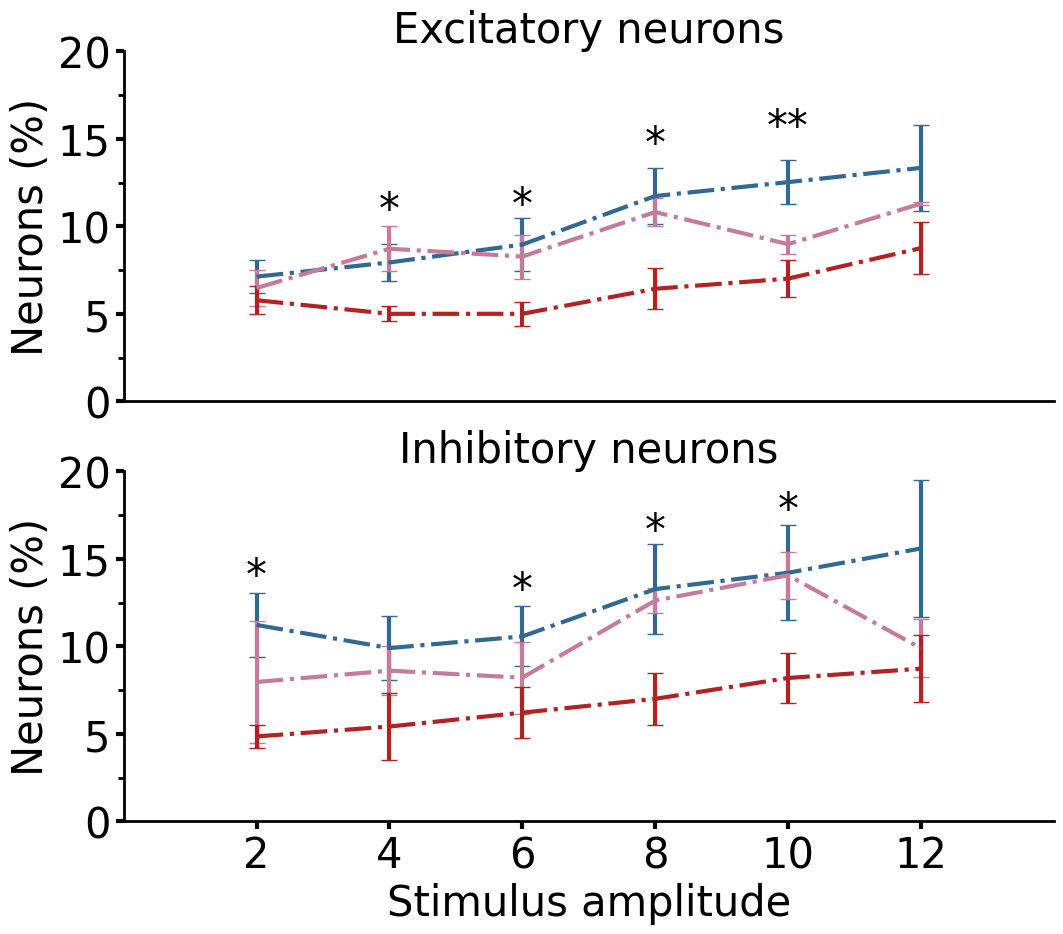

In [18]:
plot_neuron_perc_amp(recs, detected_trials=True, undetected_trials=True, signif=True, sign_exc_inh=[["n.s", "*", "*", "*", "**", "n.s"], ["*", "n.s", "*", "*", "*", "n.s"]])

## Graph of amplitude response from each stimulus amplitude


C:\Users\eFrick\AppData\Local\Temp\ipykernel_28224\3387693781.py:15: RuntimeWarning: Mean of empty slice
  output = np.nanmean(np.nanmean(trials, axis=1))


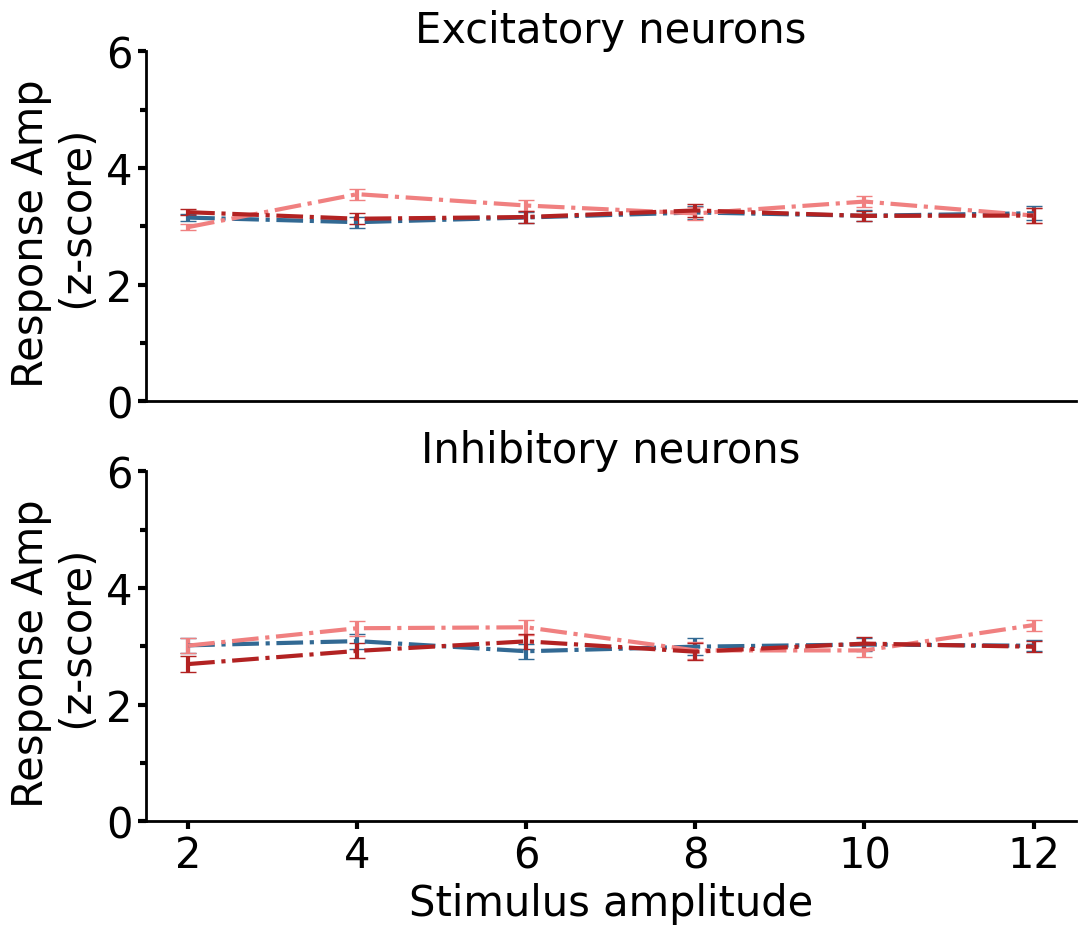

In [19]:
figs, axs = plt.subplots(2,1,figsize=(12,10))

amps=[2,4,6,8,10,12]
labels = {"EXC":"Excitatory neurons" , "INH": "Inhibitory neurons"}
for i,type in enumerate(["EXC","INH"]):
    wt,ko, ko_hypo = [],[],[]
    for rec in recs.values():
        rec.peak_delay_amp()
        mat = np.array(rec.matrices[type]["Peak_amplitude"])
        mat[mat<0]=np.nan

        _p=[]
        for amp in amps:
            trials = mat[:,rec.stim_ampl==amp]
            output = np.nanmean(np.nanmean(trials, axis=1))
            if np.isnan(output ):
                output = 0
            _p.append( output)
            
        if rec.genotype == "WT":
            wt.append(_p)

        elif rec.genotype =="KO-Hypo":
            ko_hypo.append(_p)
        elif rec.genotype =="KO":
            ko.append(_p)
        
    axs[i].errorbar(amps,np.mean(wt,axis=0),linestyle="-.",color="#326993",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15, lw=3)
    axs[i].errorbar(amps,np.mean(ko,axis=0),linestyle="-.", color="lightcoral",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15, lw=3)
    axs[i].errorbar(amps,np.mean(ko_hypo,axis=0),linestyle="-.", color="firebrick",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15, lw=3)
    axs[i].grid(False)
    axs[i].set_facecolor("white")
    axs[i].spines["left"].set_color("black")
    axs[i].yaxis.set_minor_locator(AutoMinorLocator(2))
    axs[i].tick_params(axis='both', which='major', length=6, width=3, left=True)
    axs[i].tick_params(axis='both', which='minor', length=4, width=3, left=True)
    axs[i].set_ylabel("Response Amp \n (z-score)", fontsize =30)
    axs[i].set_xlabel("Stimulus amplitude", fontsize =30)
    axs[i].set_title(labels[type], fontsize =30)
    axs[i].tick_params(axis='both', labelsize=30)
    axs[i].set_xticks([2,4,6,8,10,12])
    axs[i].set_ylim([0,6])
    axs[i].spines[['right', 'top',]].set_visible(False)
axs[0].get_xaxis().set_visible(False)

# Psychometric curves like graphs for fraction of resp neurons

Number of active neurons and behavior psychometric curves comparison animal by animals

Text(0.5, 0.98, 'Percentage of neurons recruited for all trials amplitude')

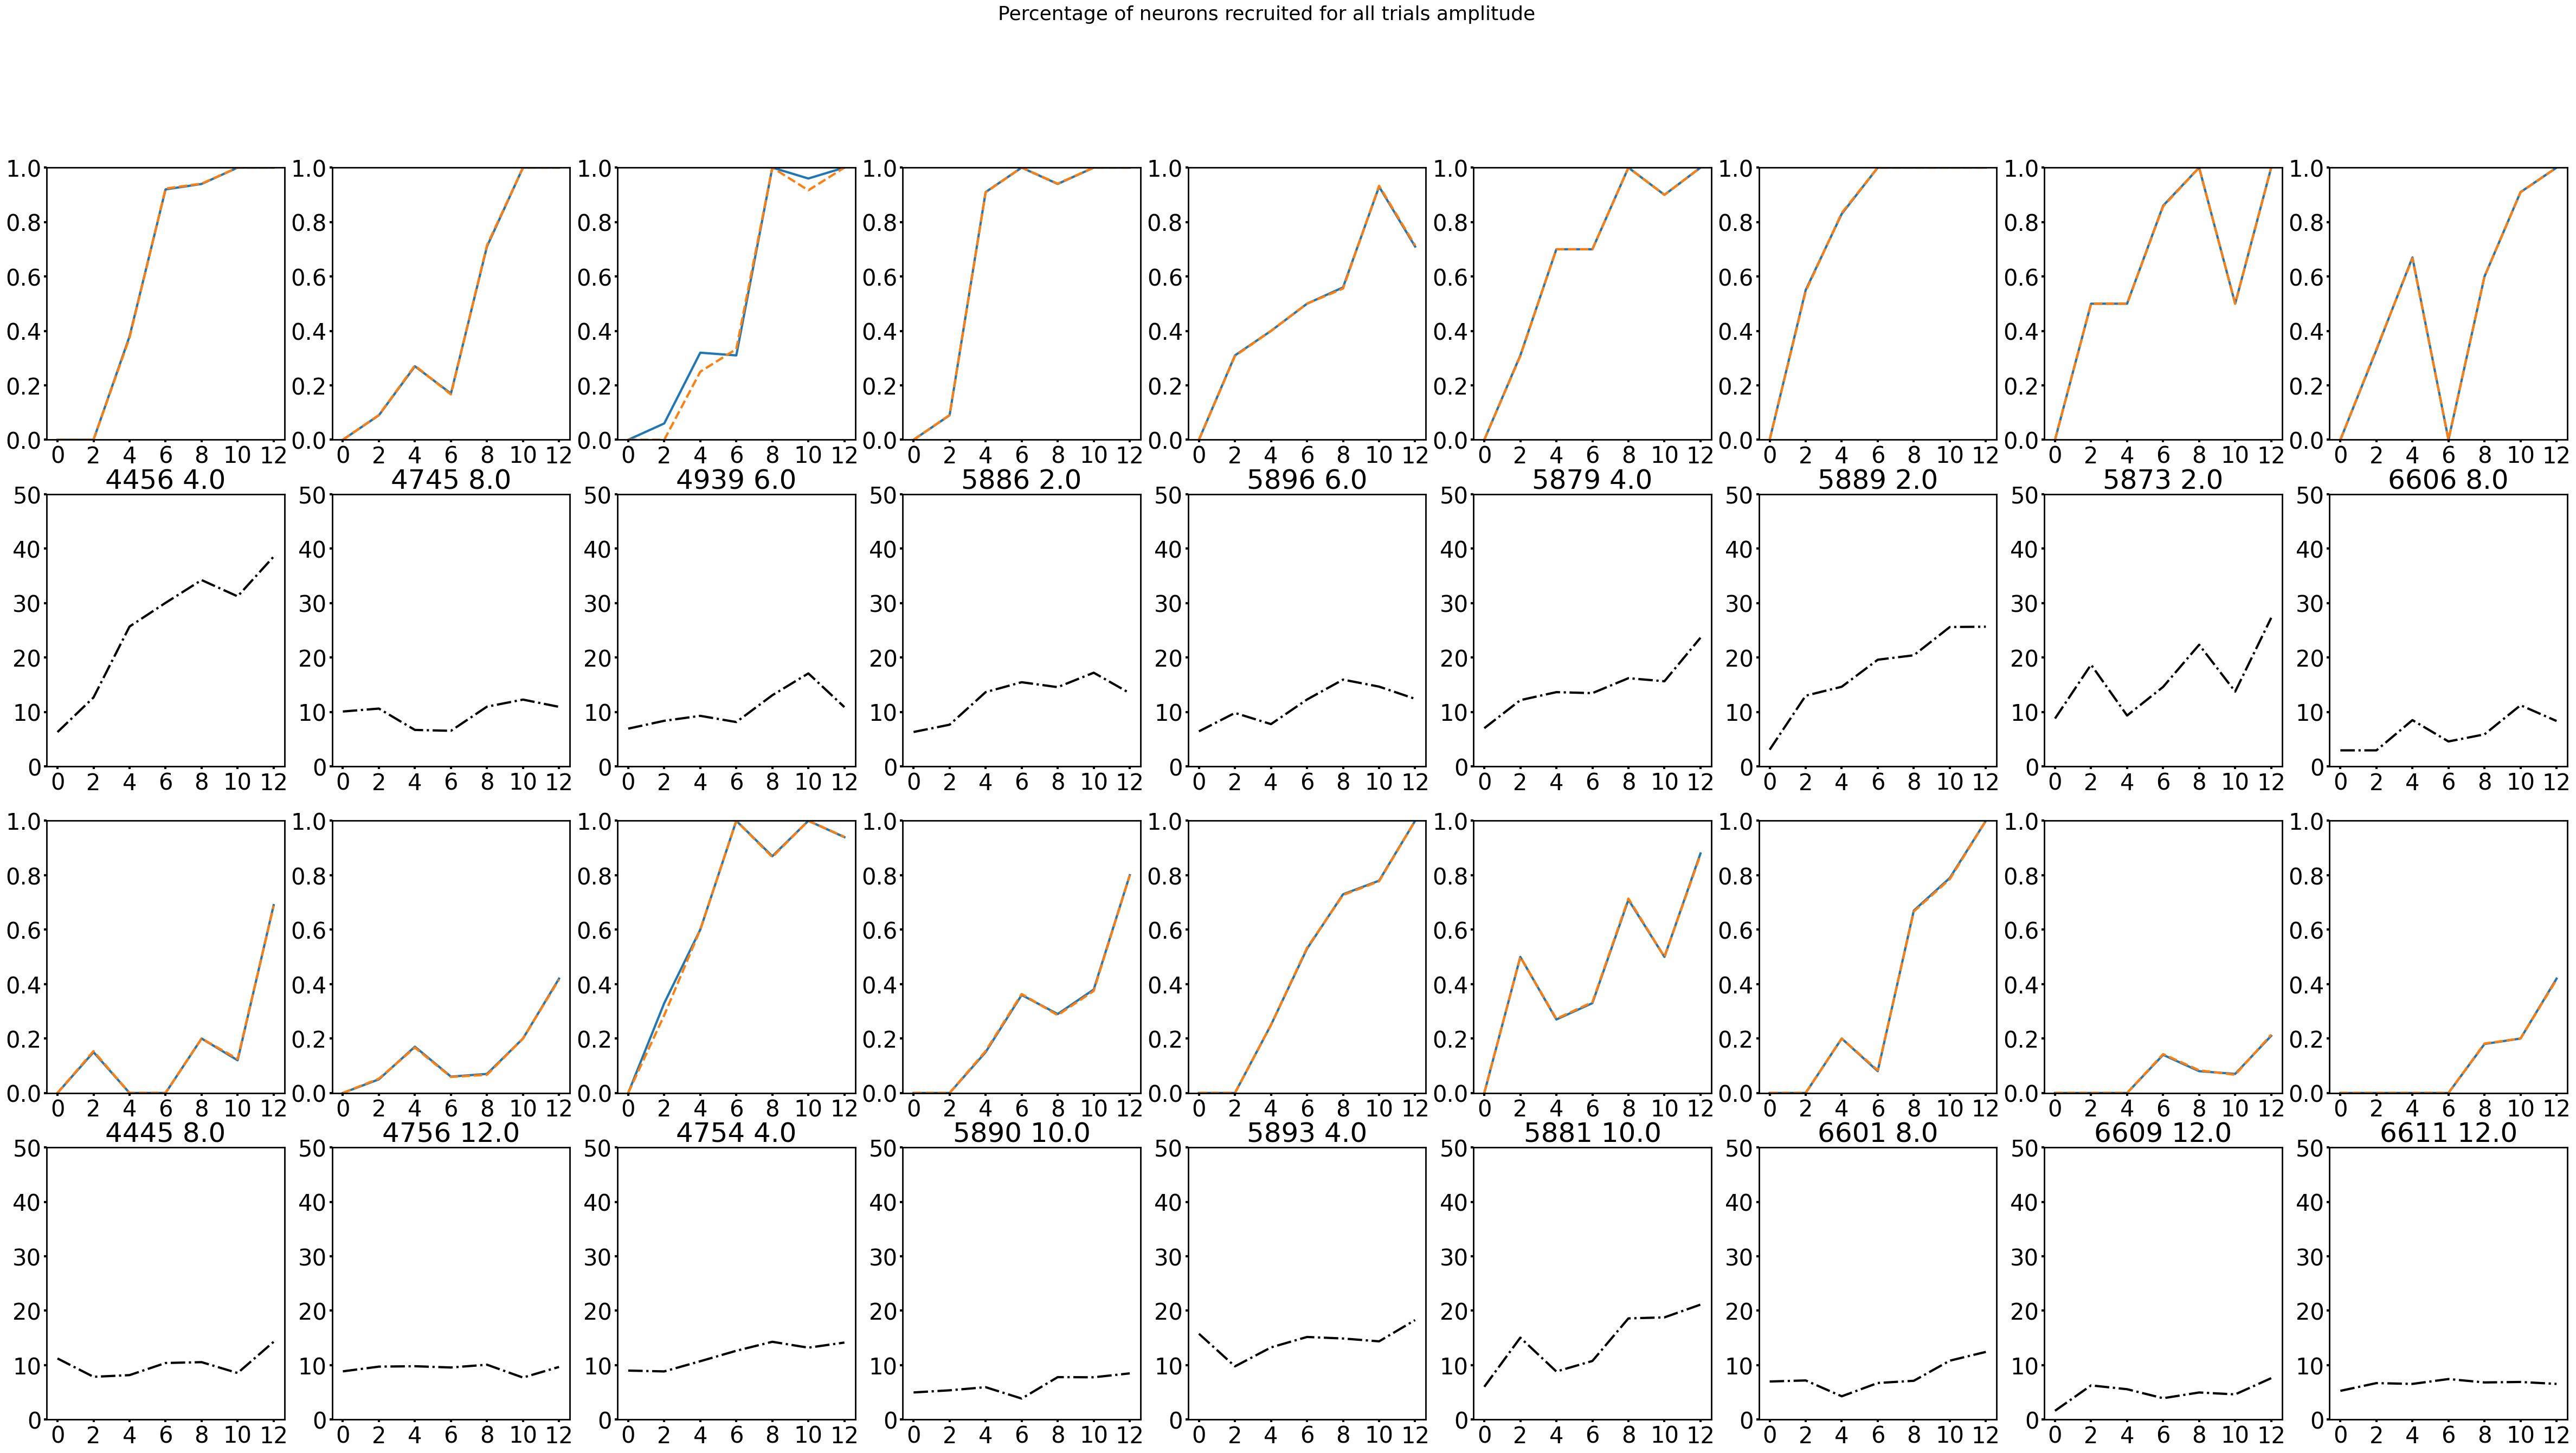

In [20]:
y, i = 0, 0
amps = [0, 2, 4, 6, 8, 10, 12]
fig, ax = plt.subplots(4, 9, figsize=(60, 30))

def neurons_recruited(ax, rec_, title):
    resp_mat = np.array(rec_.matrices["EXC"]["Responsivity"])
    resp_p = []
    trials_bsl = resp_mat[:, rec_.stim_ampl == 0]
    trials_bsl[trials_bsl != 0] = 1
    bsl_neurons = np.mean(np.count_nonzero(trials_bsl, axis=0))
    for i, amp in enumerate(amps):
        trials_ = resp_mat[:, rec_.stim_ampl == amp]
        trials_[trials_ != 0] = 1
        recruited_det = np.count_nonzero(trials_, axis=0)
        perc_n_det = ((np.mean(recruited_det)) / len(rec_.zscore_exc)) * 100
        resp_p.append(perc_n_det)
    ax.plot(amps, resp_p, linestyle="-.", color="black",
                        markersize=15)
    ax.set_title(title)
    ax.set_ylim([0,50])
for rec in recs.values():
        # rec.responsivity()
        if rec.genotype == "WT":
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[0, i])
            neurons_recruited(ax[1, i], rec,str(rec.filename) + " " +str(rec.threshold))
            ax[0, i].tick_params(axis='both', labelsize=30)
            ax[1, i].tick_params(axis='both', labelsize=30)
            ax[1, i].set_xticks([0,2,4,6,8,10,12])
            i = i + 1
        else:
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[2, y])
            neurons_recruited(ax[3, y], rec, str(rec.filename) + " " +str(rec.threshold))
            ax[2, y].tick_params(axis='both', labelsize=30)
            ax[3, y].tick_params(axis='both', labelsize=30)
            ax[3, y].set_xticks([0,2,4,6,8,10,12])
            y = y + 1
# ax[2, 6].set_axis_off()
# ax[2, 7].set_axis_off()
# ax[3, 6].set_axis_off()
# ax[3, 7].set_axis_off()
fig.suptitle('Percentage of neurons recruited for all trials amplitude', fontsize=26)

C:\Users\eFrick\PycharmProjects\Percephone\venv2\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\eFrick\PycharmProjects\Percephone\venv2\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0.98, 'Percentage of neurons recruited for DETECTED TRIALS')

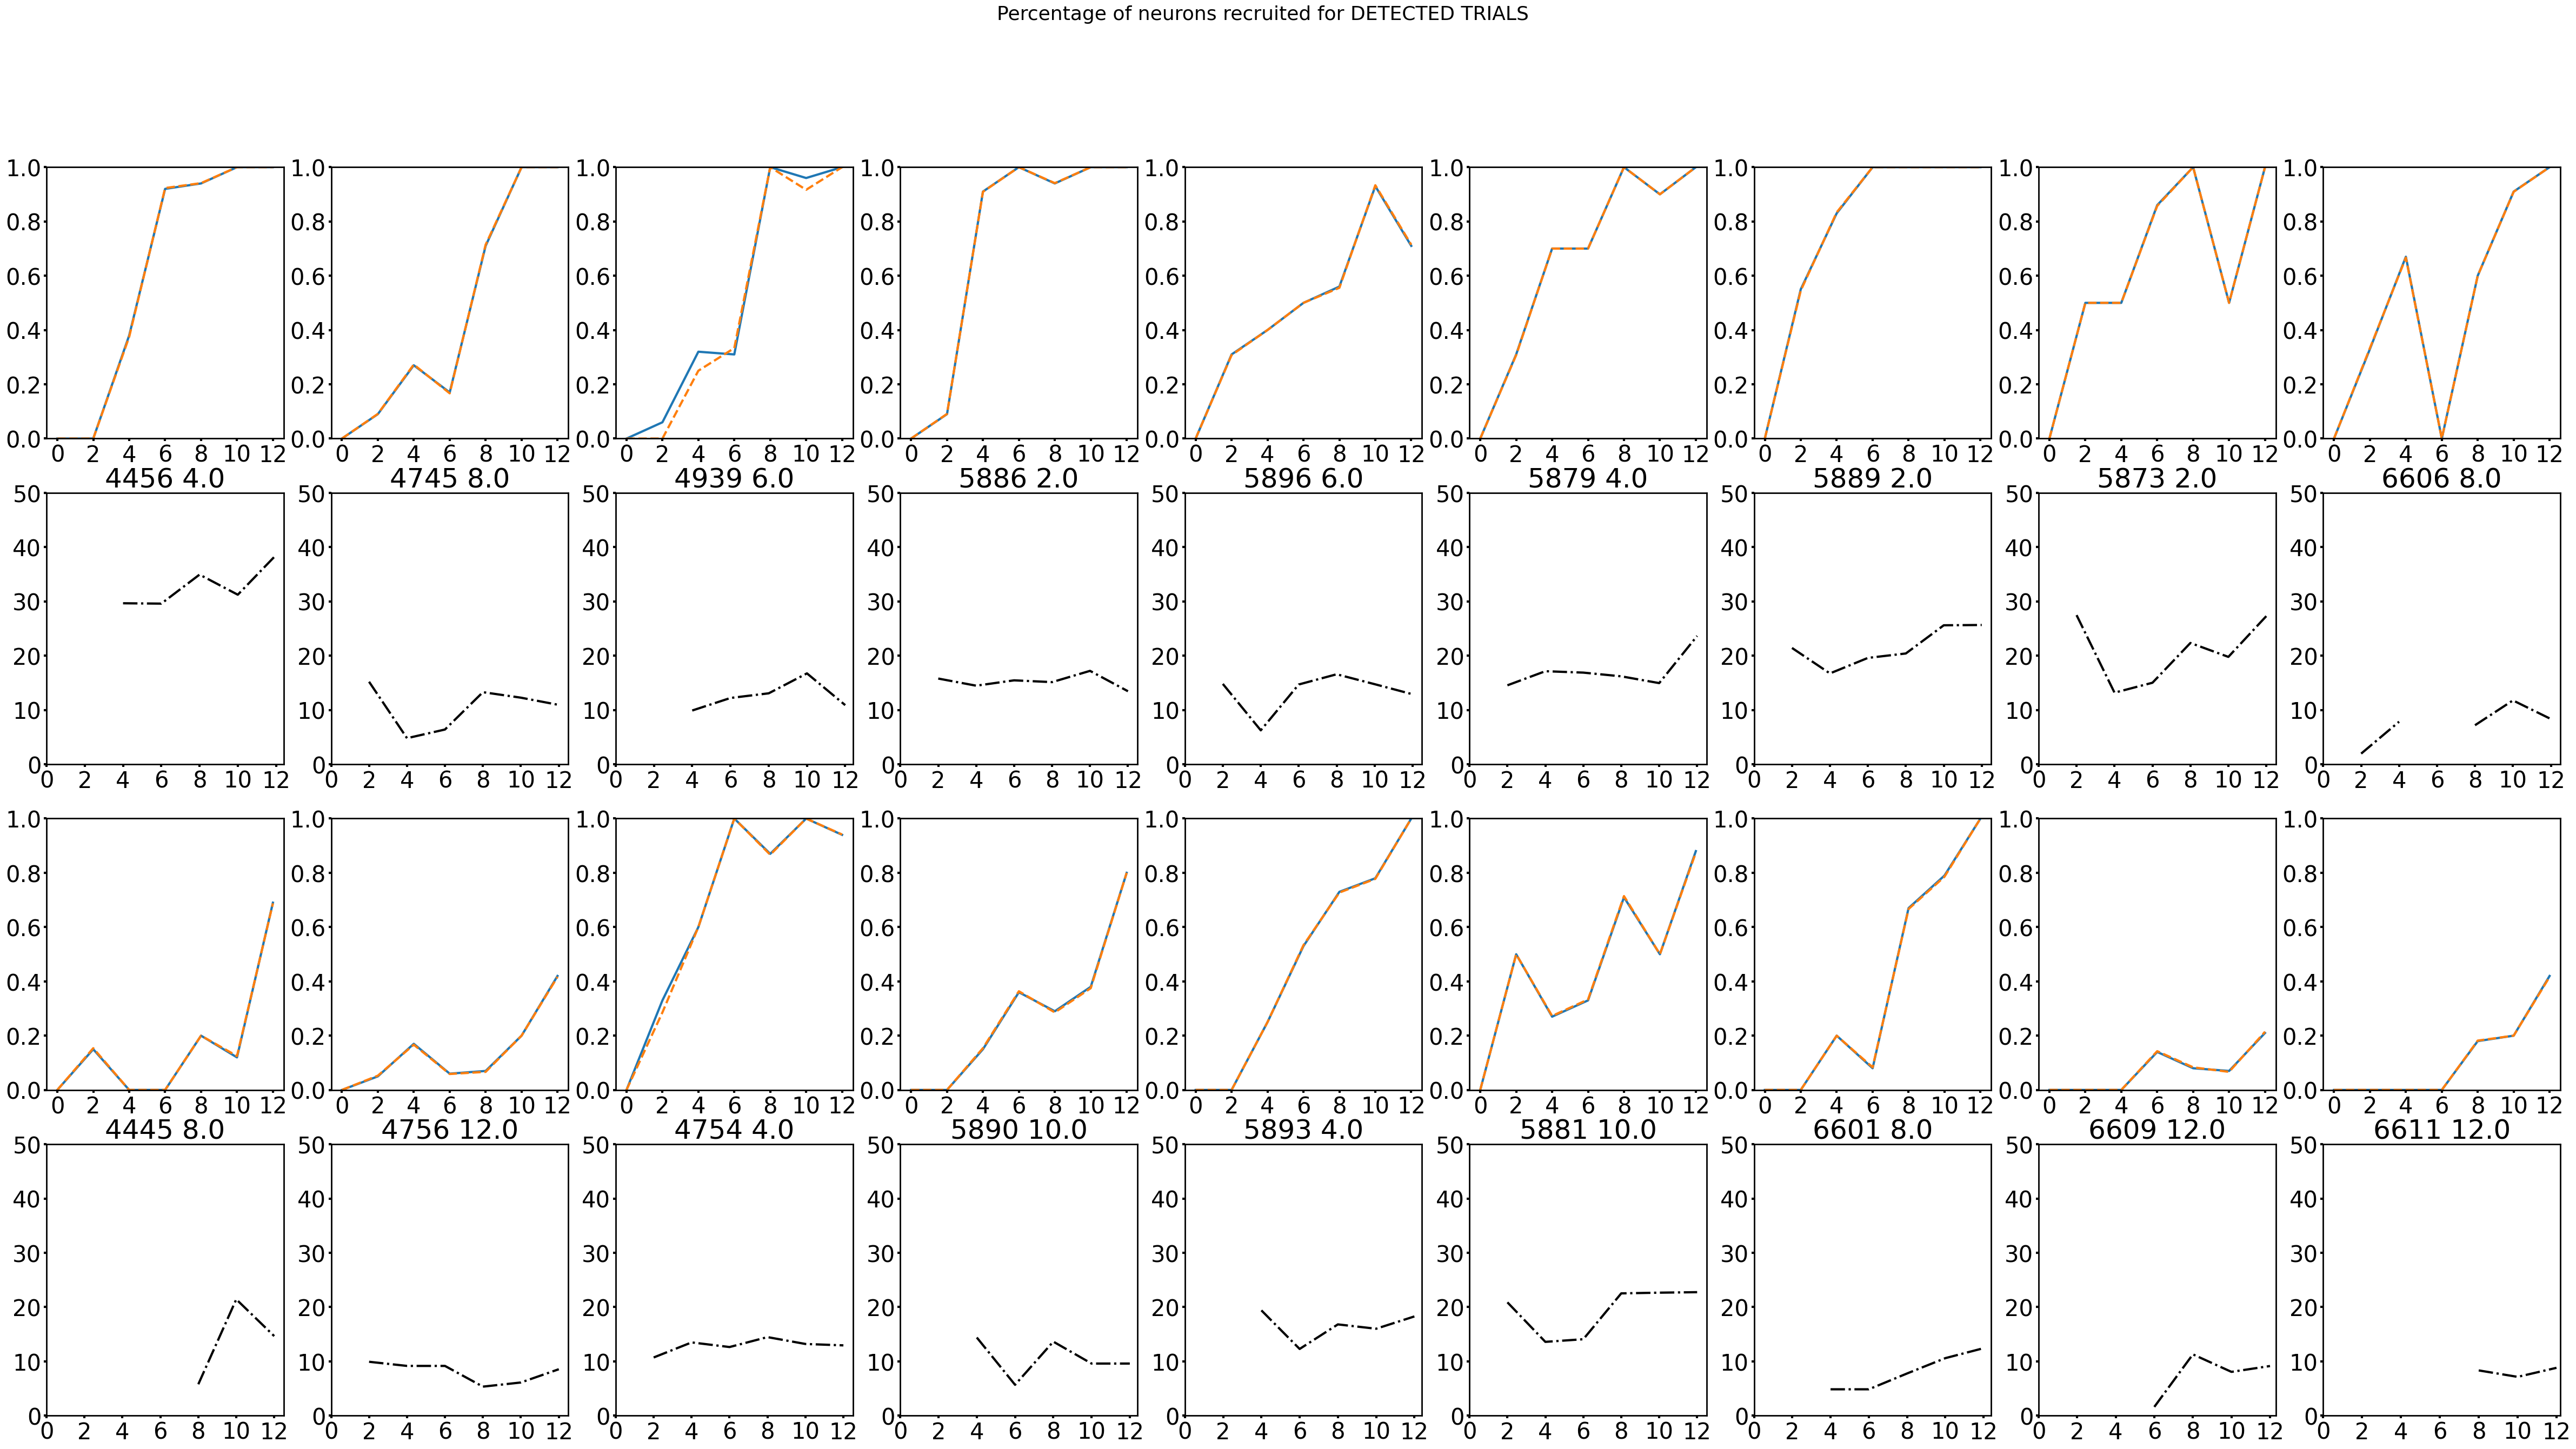

In [21]:
y, i = 0, 0
amps = [0, 2, 4, 6, 8, 10, 12]
fig, ax = plt.subplots(4, 9, figsize=(60, 30))

def neurons_recruited(ax, rec_, title):
    resp_mat = np.array(rec_.matrices["EXC"]["Responsivity"])
    resp_p = []
    trials_bsl = resp_mat[:, rec_.stim_ampl == 0]
    trials_bsl[trials_bsl != 1] = 0
    bsl_neurons = np.mean(np.count_nonzero(trials_bsl, axis=0))
    nb_trials= []
    for i, amp in enumerate(amps):
        trials_ = resp_mat[:, (rec_.stim_ampl == amp)&(rec_.detected_stim)]
        trials_[trials_ != 0] = 1
        recruited_det = np.count_nonzero(trials_, axis=0)
        perc_n_det = ((np.mean(recruited_det)) / len(rec_.zscore_exc)) * 100
        resp_p.append(perc_n_det)
        nb_trials.append(len(rec.stim_ampl[rec.stim_ampl == amp]))
    ax.plot(amps, resp_p, linestyle="-.", color="black",
                        markersize=15)
    # ax.bar([0, 2, 4, 6, 8, 10, 12], nb_trials)
    ax.set_title(title)
    ax.set_ylim([0,50])
for rec in recs.values():
        # rec.responsivity()
        if rec.genotype == "WT":
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[0, i])
            neurons_recruited(ax[1, i], rec,str(rec.filename) + " " +str(rec.threshold))
            ax[0, i].tick_params(axis='both', labelsize=30)
            ax[1, i].set_xticks([0,2,4,6,8,10,12])
            i = i + 1
        else:
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[2, y])
            neurons_recruited(ax[3, y], rec, str(rec.filename) + " " +str(rec.threshold))
            ax[2, y].tick_params(axis='both', labelsize=30)
            ax[3, y].tick_params(axis='both', labelsize=30)
            ax[3, y].set_xticks([0,2,4,6,8,10,12])
            y = y + 1
# ax[2, 6].set_axis_off()
# ax[2, 7].set_axis_off()
# ax[3, 6].set_axis_off()
# ax[3, 7].set_axis_off()
fig.suptitle('Percentage of neurons recruited for DETECTED TRIALS', fontsize=26)

percentage of neurons recruited for UNDETECTED TRIALS

4445
4456
4745
4756
4754
4939
5890
5886
5896
5893
5879
5889
5873
5881
6606
6601
6609
6611


Text(0.5, 0.98, 'Percentage of neurons recruited for UNDETECTED TRIALS')

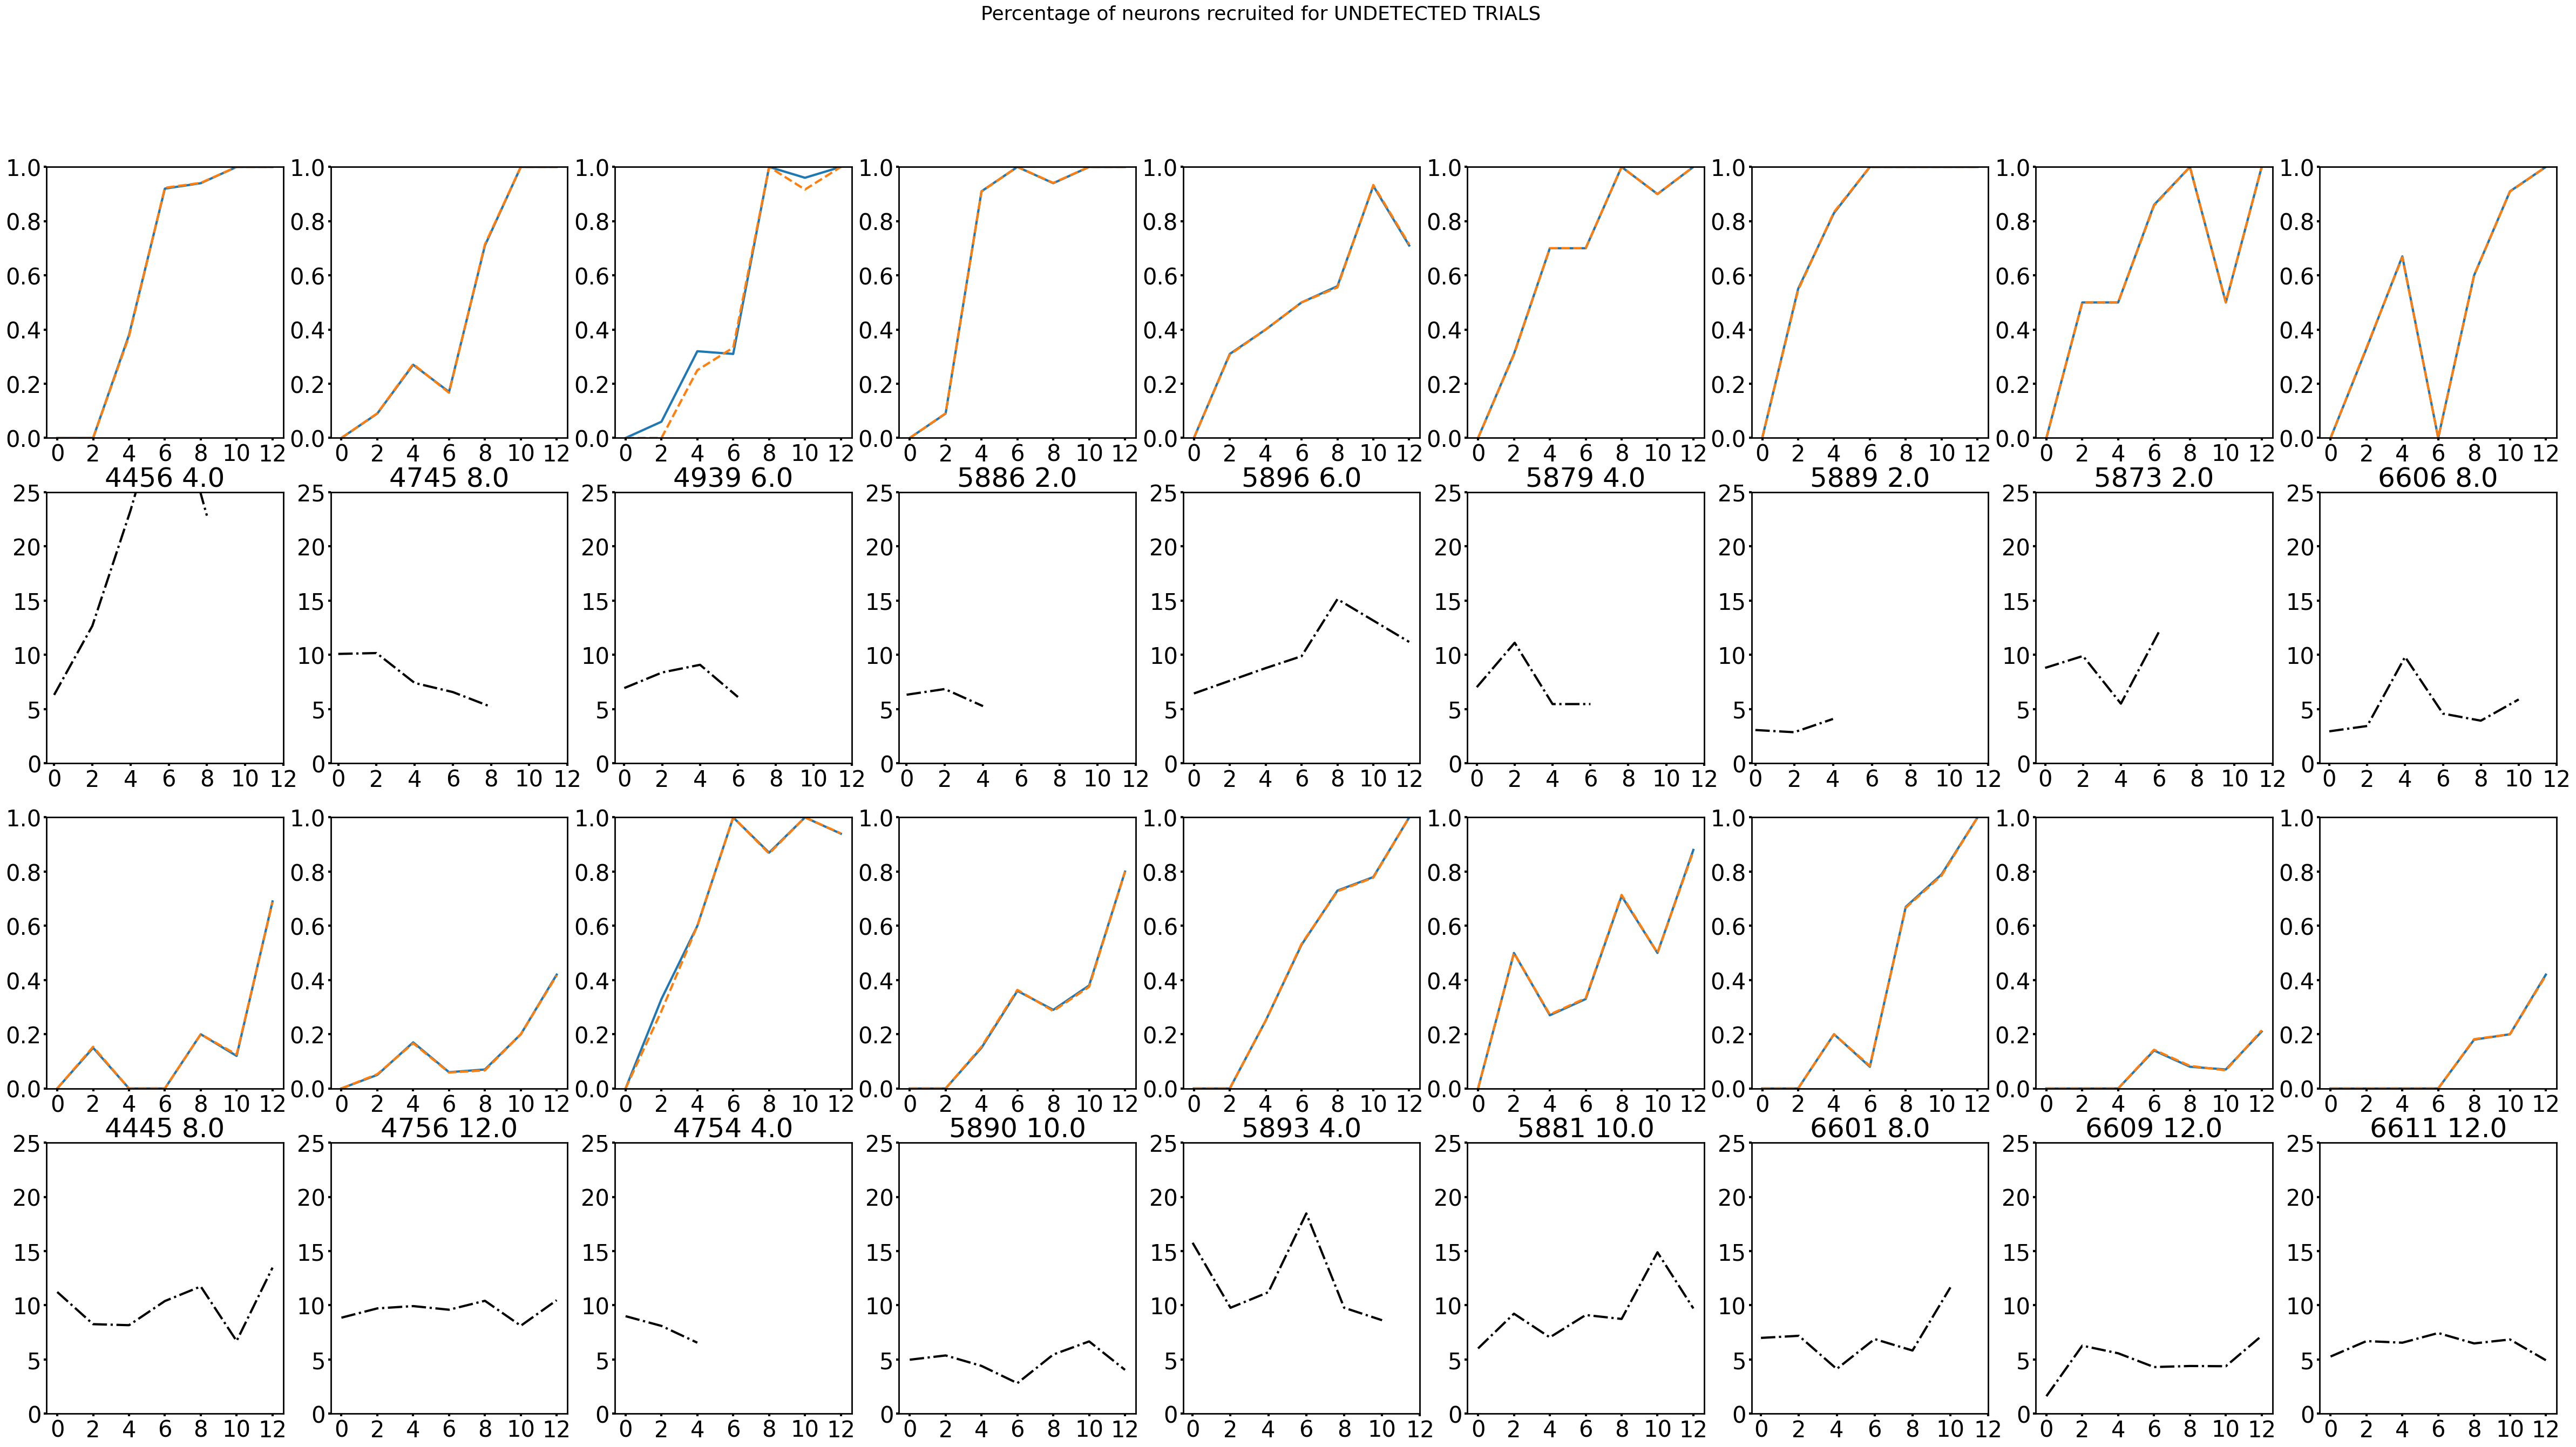

In [22]:
y, i = 0, 0
amps = [0, 2, 4, 6, 8, 10, 12]
fig, ax = plt.subplots(4, 9, figsize=(60, 30))

def neurons_recruited(ax, rec_, title):
    resp_mat = np.array(rec_.matrices["EXC"]["Responsivity"])
    resp_p = []
    trials_bsl = resp_mat[:, rec_.stim_ampl == 0]
    trials_bsl[trials_bsl != 0] = 1
    bsl_neurons = np.mean(np.count_nonzero(trials_bsl, axis=0))
    for i, amp in enumerate(amps):
        trials_ = resp_mat[:, (rec_.stim_ampl == amp)&(~rec_.detected_stim)]
        trials_[trials_ != 0] = 1
        recruited_det = np.count_nonzero(trials_, axis=0)
        perc_n_det = ((np.mean(recruited_det)) / len(rec_.zscore_exc)) * 100
        resp_p.append(perc_n_det)
    ax.plot(amps, resp_p, linestyle="-.", color="black",
                        markersize=15)
    ax.set_title(title)
    ax.set_ylim([0,25])
for rec in recs.values():
        print(rec.filename)
        # rec.responsivity()
        if rec.genotype == "WT":
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[0, i])
            neurons_recruited(ax[1, i], rec,str(rec.filename) + " " +str(rec.threshold))
            ax[0, i].tick_params(axis='both', labelsize=30)
            ax[1, i].tick_params(axis='both', labelsize=30)
            ax[1, i].set_xticks([0,2,4,6,8,10,12])

            i = i + 1
        else:
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[2, y])
            neurons_recruited(ax[3, y], rec, str(rec.filename) + " " +str(rec.threshold))
            ax[2, y].tick_params(axis='both', labelsize=30)
            ax[3, y].tick_params(axis='both', labelsize=30)
            ax[3, y].set_xticks([0,2,4,6,8,10,12])
            y = y + 1
# ax[2, 6].set_axis_off()
# ax[2, 7].set_axis_off()
# ax[3, 6].set_axis_off()
# ax[3, 7].set_axis_off()

fig.suptitle('Percentage of neurons recruited for UNDETECTED TRIALS', fontsize=26)

# Signal-to-Noise ratio (nb of neurons due to stimulus vs nb of neurons bsl) 


In [23]:
def SNR( pattern, n_type, ko, stim_ampl="all"):
    wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
    for rec in recs.values():
        # rec.responsivity()
        resp_mat = np.array(rec.matrices[n_type]["Responsivity"])
        ampl_filter = rec.stim_ampl_filter(stim_ampl=stim_ampl)
        ampl_det_filt = np.logical_and(rec.detected_stim, ampl_filter)
        ampl_undet_filt = np.logical_and(np.invert(rec.detected_stim), ampl_filter)
        #detected
        trials_detected = resp_mat[:,ampl_det_filt]
        trials_undetected = resp_mat[:,ampl_undet_filt]
        if pattern == 0:
            trials_detected[trials_detected!=0]=1
            trials_undetected[trials_undetected!=0]=1
        else:
            trials_detected[trials_detected!=pattern]=0
            trials_undetected[trials_undetected!=pattern]=0

        recruited_det = np.count_nonzero(trials_detected,axis=0)
        total_n = len(rec.zscore_exc)
        if  n_type== "INH":
            total_n = len(rec.zscore_inh)
        n_baseline = np.mean(np.count_nonzero(resp_mat[:,rec.stim_ampl==0],axis=0))
        snr_det = (((np.mean(recruited_det)-n_baseline)/total_n)*100)
        #undetected
        recruited_undet = np.count_nonzero(trials_undetected,axis=0)
        snr_undet =(((np.mean(recruited_undet)-n_baseline)/total_n)*100)
        if rec.genotype == "WT":
            wt_det.append(snr_det)
            wt_undet.append(snr_undet)
        elif rec.genotype =="KO-Hypo":
            ko_det.append(snr_det)
            ko_undet.append(snr_undet)
        elif rec.genotype == "KO" and ko =="KO":
            ko_det.append(snr_det)
            ko_undet.append(snr_undet)
    return wt_det, ko_det, wt_undet, ko_undet

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8963662266692436, pvalue=0.23168374014698145)
ShapiroResult(statistic=0.8913013822587872, pvalue=0.28152097924275216)
LeveneResult(statistic=0.7437277476034656, pvalue=0.4030005483454271)
Equal variances :TtestResult(statistic=1.9514100471007023, pvalue=0.07131045171734524, df=14.0)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8080041551934161, pvalue=0.025194205611147834)
ShapiroResult(statistic=0.9516597320308839, pvalue=0.744780983416987)
MannwhitneyuResult(statistic=37.0, pvalue=0.6064685314685315)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7616268490155889, pvalue=0.00739245951146654)
ShapiroResult(statistic=0.8700614104218866, pvalue=0.18585759117716477)
MannwhitneyuResult(statistic=41.5, pvalue=0.3142583667221204)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5276301238642018, pvalue=1.3511595234788798e-05)
ShapiroResult(statistic=0.7733777220361945, pvalue=0.022

Text(0.5, 1.0, 'SNR INH Undetected')

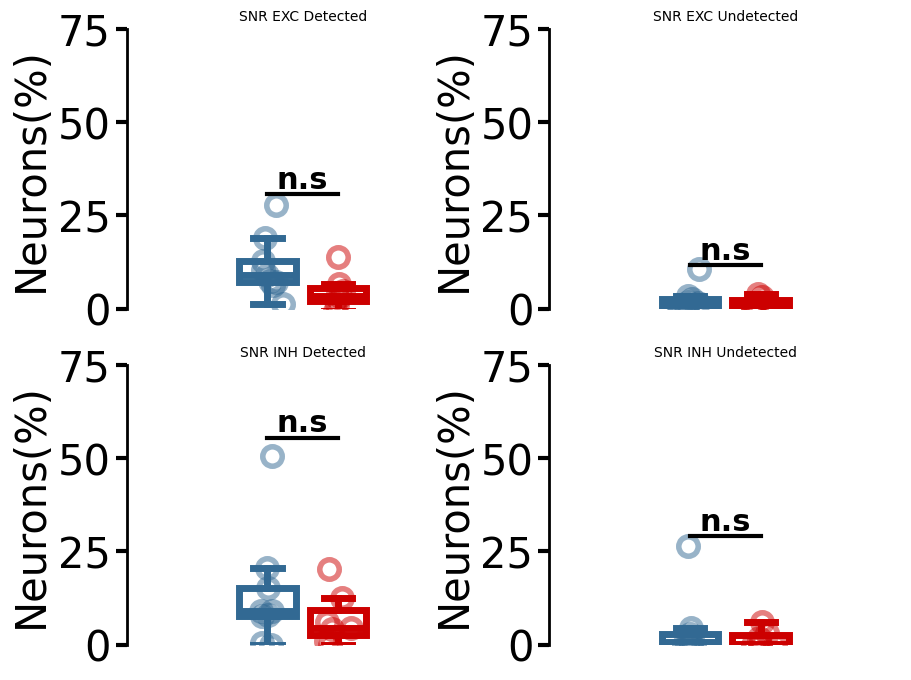

In [24]:
    wt_det, ko_det, wt_undet, ko_undet = SNR(pattern=0, n_type="EXC", ko="KO-hypo", stim_ampl="all")
    fig, axs = plt.subplots(2, 2, figsize=(10,8))
    ylim= [0,70]
    ppt.boxplot(axs[0, 0], wt_det,ko_det,"Neurons(%)",ylim=ylim)
    axs[0, 0].set_title("SNR EXC Detected", fontsize=10)
    ppt.boxplot(axs[0, 1], wt_undet,ko_undet,"Neurons(%)",ylim=ylim)
    axs[0, 1].set_title("SNR EXC Undetected", fontsize=10)
    wt_det1, ko_det1, wt_undet1, ko_undet1 = fraction_resp(pattern=0, n_type="INH", ko="ko-hypo", stim_ampl="all")
    ppt.boxplot(axs[1, 0], wt_det1,ko_det1,"Neurons(%)",ylim=ylim)
    axs[1, 0].set_title("SNR INH Detected", fontsize=10)
    ppt.boxplot(axs[1, 1], wt_undet1,ko_undet1,"Neurons(%)",ylim=ylim)
    axs[1, 1].set_title("SNR INH Undetected", fontsize=10)

# Fraction of neurons active during no-Gos

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9106459544006728, pvalue=0.32042181603225645)
ShapiroResult(statistic=0.9794650479087065, pvalue=0.956901077508393)
LeveneResult(statistic=0.4359231599782149, pvalue=0.5198126667866313)
Equal variances :TtestResult(statistic=0.00571420925200509, pvalue=0.9955213722624772, df=14.0)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.877368341824464, pvalue=0.14729783501690508)
ShapiroResult(statistic=0.9223700695378059, pvalue=0.48803010232608907)
LeveneResult(statistic=1.6666615226937476, pvalue=0.21761764644711884)
Equal variances :TtestResult(statistic=1.069188975663688, pvalue=0.3030733908993576, df=14.0)


Text(0.5, 1.0, 'nogo EXC Undetected')

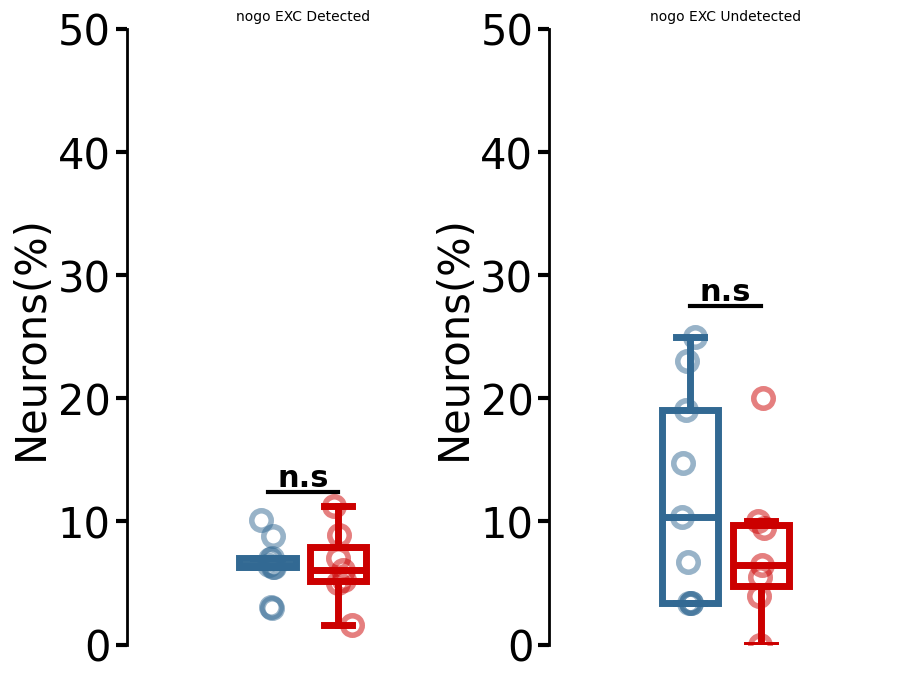

In [25]:
def nogo_fraction(pattern, n_type, ko):
    wt_det, wt_undet, ko_det, ko_undet = [], [], [], []
    for rec in recs.values():
        # rec.responsivity()
        resp_mat = rec.matrices["EXC"]["Responsivity"]
        total_n = len(rec.zscore_exc)
        if n_type == "INH":
            resp_mat = rec.matrices["INH"]["Responsivity"]
            total_n = len(rec.zscore_inh)

        n_baseline = (np.mean(np.count_nonzero(resp_mat[:, rec.stim_ampl == 0], axis=0)) / total_n) * 100
        if rec.genotype == "WT":
            wt_det.append(n_baseline)
        elif rec.genotype == "KO-Hypo":
            ko_det.append(n_baseline)

        elif rec.genotype == "KO" and ko == "KO":
            ko_det.append(n_baseline)

    return wt_det, ko_det
wt_det, ko_det = nogo_fraction(pattern=0, n_type="EXC", ko="KO-hypo")
wt_det1, ko_det1 = nogo_fraction(pattern=0, n_type="INH", ko="ko-hypo")
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
ylim = [0, 50]
ppt.boxplot(axs[0], wt_det, ko_det, "Neurons(%)", ylim=ylim)
axs[0].set_title("nogo EXC Detected", fontsize=10)
ppt.boxplot(axs[1], wt_det1, ko_det1, "Neurons(%)", ylim=ylim)
axs[1].set_title("nogo EXC Undetected", fontsize=10)

## Level of inhibition (nb of exc inhibited/ nb of inh activated) (No nogo normalization)

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8823474263023301, pvalue=0.16618453367098807)
ShapiroResult(statistic=0.7777587589130643, pvalue=0.024513708954403447)
MannwhitneyuResult(statistic=42.0, pvalue=0.29912587412587416)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7944999152661002, pvalue=0.017668471375771384)
ShapiroResult(statistic=0.8454357503691787, pvalue=0.11158826258812654)
MannwhitneyuResult(statistic=28.0, pvalue=0.7576923076923078)


Text(0.5, 1.0, 'EXC Undetected')

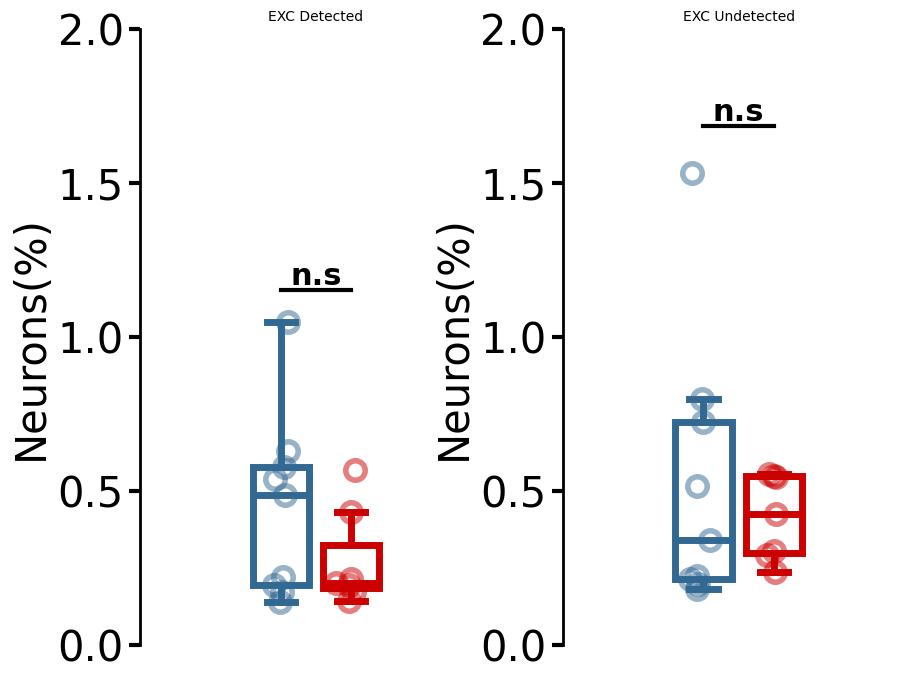

In [26]:
wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=-1, n_type="EXC", ko=False, stim_ampl="all",
                                                   no_go_normalize=False)
wt_det1, ko_det1, wt_undet1, ko_undet1 = fraction_resp(pattern=1, n_type="INH", ko=False, stim_ampl="all",
                                                       no_go_normalize=False)
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
ylim = [0, 2]
ppt.boxplot(axs[0], np.divide(wt_det, wt_det1), np.divide(ko_det, ko_det1), "Neurons(%)", ylim=ylim)
axs[0].set_title("EXC Detected", fontsize=10)
ppt.boxplot(axs[1], np.divide(wt_undet, wt_undet1), np.divide(ko_undet, ko_undet1), "Neurons(%)", ylim=ylim)
axs[1].set_title("EXC Undetected", fontsize=10)

# E/I ratio 

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8363905207851572, pvalue=0.0526465586412043)
ShapiroResult(statistic=0.8478032911878906, pvalue=0.11733243910275465)
LeveneResult(statistic=0.03695300918036356, pvalue=0.8503212094025258)
Equal variances :TtestResult(statistic=0.0012585222741377227, pvalue=0.9990136020948482, df=14.0)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.771008944416348, pvalue=0.00948801488084916)
ShapiroResult(statistic=0.846728236077845, pvalue=0.11469157378115508)
MannwhitneyuResult(statistic=17.0, pvalue=0.14160839160839161)


Text(0.5, 1.0, 'EXC Undetected')

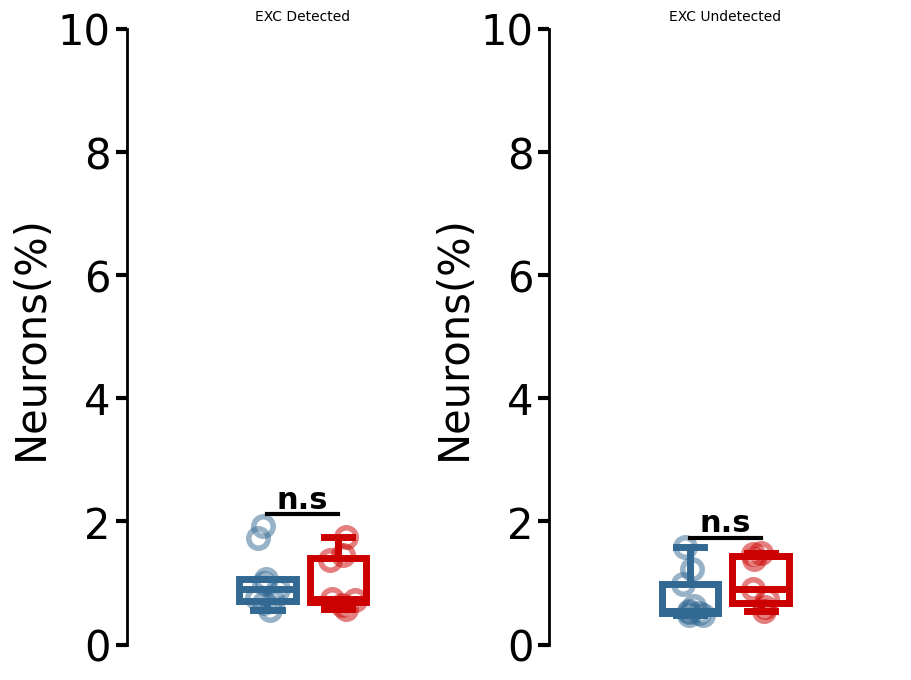

In [27]:
wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=1, n_type="EXC", ko=False, stim_ampl="all", no_go_normalize=False)
wt_det1, ko_det1, wt_undet1, ko_undet1 = fraction_resp(pattern=1, n_type="INH", ko=False, stim_ampl="all", no_go_normalize=False)
ylim =[0,10]
fig, axs = plt.subplots(1, 2, figsize=(10,8))
y0=np.round(np.divide(wt_det,wt_det1),3)
y1=np.round(np.divide(ko_det,ko_det1),3)
ppt.boxplot(axs[0],y0 ,y1,"Neurons(%)",ylim=ylim)
axs[0].set_title("EXC Detected", fontsize=10)
y2=np.round(np.divide(wt_undet,wt_undet1),3)
y3=np.round(np.divide(ko_undet,ko_undet1),3)
ppt.boxplot(axs[1],y2[np.isfinite(y2)], y3[np.isfinite(y3)],"Neurons(%)",ylim=ylim)
axs[1].set_title("EXC Undetected", fontsize=10)


In [97]:
def quantify_neur(n_type, ko="all"):
    wt_n, ko_n, wt_per, ko_per = [],[],[],[]
    for rec in recs.values():
        if n_type == "EXC":
            n_neur = rec.zscore_exc.shape[0]
            n_perc = (rec.zscore_exc.shape[0]/(rec.zscore_exc.shape[0]+rec.zscore_inh.shape[0]))*100
        
        elif n_type == "INH":
            n_neur = rec.zscore_inh.shape[0]
            n_perc = (rec.zscore_inh.shape[0]/(rec.zscore_inh.shape[0]+rec.zscore_exc.shape[0]))*100

            
        if rec.genotype == "WT":
            wt_n.append(n_neur)
            wt_per.append(n_perc)
        elif rec.genotype =="KO-Hypo":
            ko_n.append(n_neur)
            ko_per.append(n_perc)
        elif rec.genotype == "KO" and ko =="KO":
            ko_n.append(n_neur)
            ko_per.append(n_perc)
        
    return wt_n, ko_n, wt_per, ko_per

In [98]:
quantify_neur("EXC")

([127, 125, 101, 38, 76, 55, 49, 91, 51],
 [98, 131, 66, 103, 103, 62, 84],
 [90.0709219858156,
  86.20689655172413,
  84.16666666666667,
  80.85106382978722,
  88.37209302325581,
  75.34246575342466,
  76.5625,
  75.83333333333333,
  77.27272727272727],
 [87.5,
  91.6083916083916,
  76.74418604651163,
  84.42622950819673,
  82.39999999999999,
  88.57142857142857,
  82.35294117647058])

Boxplot plotting.
--- Nb Neurons ---
ShapiroResult(statistic=0.9076382047186158, pvalue=0.2996925304219764)
ShapiroResult(statistic=0.959431986246836, pvalue=0.7923554776467305)
LeveneResult(statistic=0.4644913627639156, pvalue=0.5052784604066094)
Equal variances :TtestResult(statistic=-0.25861683249457174, pvalue=0.7992283626794601, df=16.0)
Boxplot plotting.
--- Nb Neurons ---
ShapiroResult(statistic=0.9273854656802926, pvalue=0.4568551541196089)
ShapiroResult(statistic=0.954652114702565, pvalue=0.7410353535277097)
LeveneResult(statistic=0.03574975173783509, pvalue=0.8524108190786044)
Equal variances :TtestResult(statistic=0.7259776261176547, pvalue=0.4783385403253051, df=16.0)
Boxplot plotting.
--- % Neurons ---
ShapiroResult(statistic=0.8921495679092057, pvalue=0.2099138921611129)
ShapiroResult(statistic=0.959623734936737, pvalue=0.7943729387855286)
LeveneResult(statistic=0.8392469614302966, pvalue=0.373214022349013)
Equal variances :TtestResult(statistic=-1.3513490219048259, pvalu

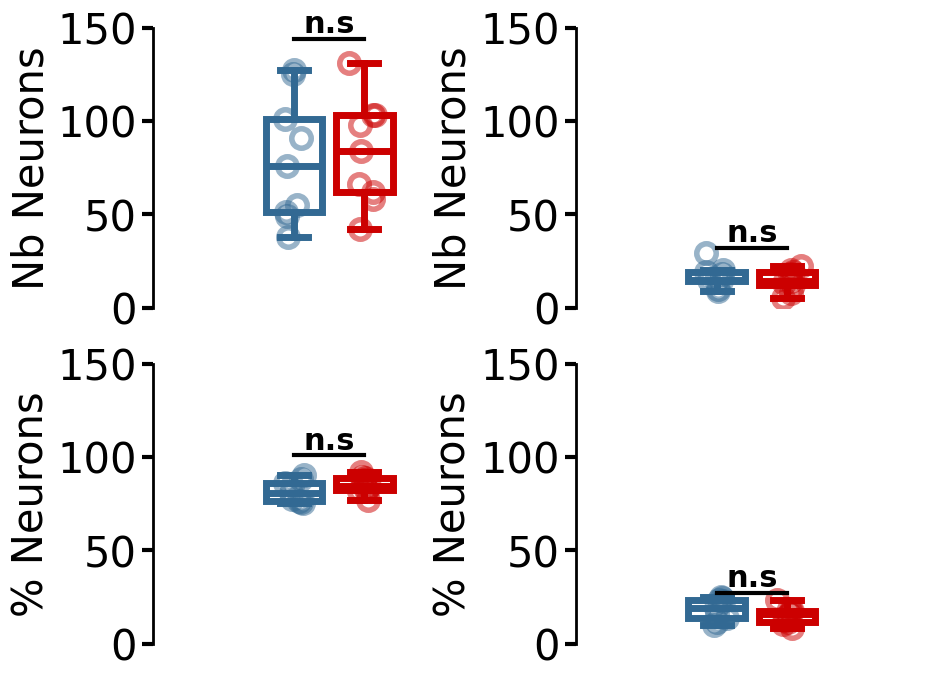

In [100]:
wt_exc, ko_exc, wt_per_e, ko_per_e = quantify_neur("EXC",ko="KO")
wt_inh, ko_inh, wt_per_i, ko_per_i = quantify_neur("INH",ko="KO")
fig, axs = plt.subplots(2, 2, figsize=(10,8))
ylim = [0, 150]
ppt.boxplot(axs[0,0],wt_exc ,ko_exc,"Nb Neurons",ylim=ylim)
ppt.boxplot(axs[0,1],wt_inh ,ko_inh,"Nb Neurons",ylim=ylim)
ppt.boxplot(axs[1,0],wt_per_e ,ko_per_e,"% Neurons",ylim=ylim)
ppt.boxplot(axs[1,1],wt_per_i ,ko_per_i,"% Neurons",ylim=ylim)
